# Прогнозирование оттока клиентов в телеком-компании

## Введение

### Описание заказчика
Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны дополнительные услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
- Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

### Описание проекта
Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

### Задача проекта
Разработать решение, которое позволит на основании собранных командой "ТелеДома" данных предсказывать, разорвет ли клиент договор.

### Цель проекта
Предоставить заказчику обоснованные рекомендации для удержания склонных к "отвалу" клиентов. ROC-AUC 0.9

### Описание данных
Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре
    - customerID — идентификатор абонента;
    - BeginDate — дата начала действия договора;
    - EndDate — дата окончания действия договора;
    - Type — тип оплаты: раз в год-два или ежемесячно;
    - PaperlessBilling — электронный расчётный лист;
    - PaymentMethod — тип платежа;
    - MonthlyCharges — расходы за месяц;
    - TotalCharges — общие расходы абонента. 
- `personal_new.csv` — персональные данные клиента
    - customerID — идентификатор пользователя;
    - gender — пол;
    - SeniorCitizen — является ли абонент пенсионером;
    - Partner — есть ли у абонента супруг или супруга;
    - Dependents — есть ли у абонента дети.
- `internet_new.csv` — информация об интернет-услугах
    - customerID — идентификатор пользователя;
    - InternetService — тип подключения;
    - OnlineSecurity — блокировка опасных сайтов;
    - OnlineBackup — облачное хранилище файлов для резервного копирования данных;
    - DeviceProtection — антивирус;
    - TechSupport — выделенная линия технической поддержки;
    - StreamingTV — стриминговое телевидение;
    - StreamingMovies — каталог фильмов.
- `phone_new.csv` — информация об услугах телефонии
    - customerID — идентификатор пользователя;
    - MultipleLines — подключение телефона к нескольким линиям одновременно.


### План работ
1. Загрузить данные
2. Предобработка данных
3. Исследовательский анализ данных (EDA)
4. Подготовка данных (объединение данных из всех таблиц)
5. Обучение моделей
6. Объяснение модели, выводы

### Import dependencies

In [1]:
#!pip install numpy 
#!pip install matplotlib 
#!pip install pandas 
#!pip install seaborn 
#!pip install scikit-learn==1.6.1 
#!pip install catboost 
#!pip install numba -U
#!pip install shap==0.46.0
#!pip install phik

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    OneHotEncoder
)
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    roc_curve
)
import scipy.stats as st
from catboost import CatBoostClassifier
from phik import phik_matrix
import shap

## Загрузка данных 

In [3]:
contract_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1Ks0LLeq_ddXRC0WgsLZyUuGq1HzYDE7p')
personal_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1N3q4O0eP1mnq_TryImAW2V2yxEJFTmx0')
internet_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1aeSwUGJM60Oe_uf_VsxiNOMYIz3EQnOo')
phone_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1Daqk-GhU_HynN6eN9w5JH8-cfnSOepTm')

### Первоначальное изучение данных

In [4]:
# Функция для визуализации
def display_general(dataframe):
    display(dataframe.head())
    display(dataframe.info())

In [5]:
display_general(contract_data)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Данные соответствуют описанию. Так как у нас в явном виде не указан целевой признак, нам необходимо выделить его самостоятельно из EndDate. Выделим его на этапе предобработки. Типы данных BeginDate необходимо заменить на datetime, TotalCharges на float. Пропуски NaN отсутствуют.

In [6]:
display_general(personal_data)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Данные соответствуют описанию. Типы данных можно оставить как есть. Пропуски NaN отсутствуют.

In [7]:
display_general(internet_data)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Данные соответствуют описанию. Типы данных можно оставить как есть. Пропуски NaN отсутствуют.

In [8]:
display_general(phone_data)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Данные соответствуют описанию. Типы данных можно оставить как есть. Пропуски NaN отсутствуют.

### Вывод по загрузке данных
- Данные соответствуют описанию;
- Пропуски NaN отсутствуют;
- Типы данных BeginDate необходимо заменить на datetime, TotalCharges на float, остальные можно оставить как есть;
- Необходимо извлечь целевой признак из EndDate.

## Предобработка данных
1. Обработка названий столбцов
2. Выделение целевого признака
3. Обработка типов данных
4. Обработка дубликатов

### Названия столбцов

In [9]:
contract_data.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges']
personal_data.columns = ['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
internet_data.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
phone_data.columns = ['customer_id', 'multiple_lines']

### Целевой признак

Нам необходимо разметить строки, где договор закончился - то есть значение отлично от 'No'. 1 - если клиент ушел и 0, если нет.

In [10]:
# Функция для извлечения целевого признака
def extract_target(end_date):
    if end_date == 'No':
        return 0
    else:
        return 1

contract_data['leaving'] = contract_data['end_date'].apply(extract_target)
contract_data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,leaving
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


Добавлен целевой признак `'leaving'`.

### Типы данных

In [11]:
contract_data['begin_date'] = contract_data['begin_date'].apply(pd.to_datetime)

Вероятно, `contract_data['total_charges']` типа object, потому что среди значений есть не свойственные для float значения. Проверим, так ли это.

In [12]:
sorted(contract_data['total_charges'].unique())

[' ',
 '100.17',
 '100.19',
 '100.2',
 '100.24',
 '100.25',
 '100.4',
 '100.75',
 '100.88',
 '100.9',
 '100.94',
 '1000.0',
 '1000.12',
 '1000.43',
 '1001.0',
 '1001.1',
 '1001.81',
 '1002.05',
 '1002.13',
 '1002.46',
 '1003.15',
 '1003.93',
 '1004.08',
 '1005.2',
 '1005.3',
 '1006.0',
 '1006.95',
 '1007.1',
 '1007.5',
 '1008.37',
 '1008.45',
 '1008.48',
 '1008.58',
 '1008.6',
 '1008.8',
 '1009.65',
 '1009.8',
 '101.0',
 '101.2',
 '101.25',
 '101.75',
 '1010.1',
 '1010.65',
 '1011.66',
 '1012.35',
 '1012.5',
 '1013.27',
 '1013.5',
 '1014.75',
 '1015.07',
 '1015.2',
 '1016.6',
 '1017.45',
 '1017.9',
 '1018.37',
 '1018.77',
 '1018.8',
 '1019.4',
 '102.01',
 '102.25',
 '102.38',
 '102.41',
 '102.61',
 '102.64',
 '102.75',
 '102.8',
 '1020.6',
 '1021.76',
 '1021.8',
 '1023.51',
 '1023.8',
 '1023.85',
 '1024.06',
 '1024.1',
 '1027.31',
 '1028.98',
 '1028.99',
 '103.25',
 '103.52',
 '103.55',
 '103.84',
 '1030.26',
 '1031.05',
 '1032.2',
 '1032.35',
 '1033.6',
 '1033.85',
 '1034.28',
 '1035.

Среди значений присутствует пробел '  ', и он не может быть преобразован в число с плавающей точкой. Изучим эти данные дательнее.

In [13]:
contract_data[contract_data['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,leaving
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0


Так как в нашем распоряжении данные, актуальные для 01 февраля 2020 года, мы можем заполнить эти значения значениями monthly_charges (это ровно они и есть), так как дата начала договора этих клиентов как раз 01 февраля 2020 года, то есть клиент только заключил договор и система не посчитала историческими данными данные о их расходах.

In [14]:
contract_data.loc[contract_data['total_charges'] == ' ', 'total_charges'] = (
contract_data[contract_data['total_charges'] == ' ']['monthly_charges']
)
contract_data['total_charges'] = contract_data['total_charges'].astype('float')
len(contract_data[contract_data['total_charges'] == ' '])

0

### Дубликаты

#### Явные дубликаты

In [15]:
contract_data.duplicated().sum()

0

In [16]:
personal_data.duplicated().sum()

0

In [17]:
internet_data.duplicated().sum()

0

In [18]:
phone_data.duplicated().sum()

0

Явные дубликаты отсутствуют. Если все customer_id уникальны, значит дубликатов в данных нет.

#### Неявные дубликаты

In [19]:
# Списки для хранения названий признаков, где могут быть неявные дубликаты
contract_list = ['type', 'paperless_billing', 'payment_method']
personal_list = ['gender', 'senior_citizen', 'partner', 'dependents']
internet_list = ['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']
phone_list = ['multiple_lines']

# Функция для проверки дубликатов
def show_duplicated(dataframe, cat_list):
    for feature in cat_list:
        print(f"feature: {feature}\nunique values:")
        print(dataframe[feature].unique(), '\n')

#### contract_data

In [20]:
show_duplicated(contract_data, contract_list)

feature: type
unique values:
['Month-to-month' 'One year' 'Two year'] 

feature: paperless_billing
unique values:
['Yes' 'No'] 

feature: payment_method
unique values:
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)'] 



Неявные дубликаты отсутствуют.

#### personal_data

In [21]:
show_duplicated(personal_data, personal_list)

feature: gender
unique values:
['Female' 'Male'] 

feature: senior_citizen
unique values:
[0 1] 

feature: partner
unique values:
['Yes' 'No'] 

feature: dependents
unique values:
['No' 'Yes'] 



Неявные дубликаты отсутствуют.

#### internet_data

In [22]:
show_duplicated(internet_data, internet_list)

feature: internet_service
unique values:
['DSL' 'Fiber optic'] 

feature: online_security
unique values:
['No' 'Yes'] 

feature: online_backup
unique values:
['Yes' 'No'] 

feature: device_protection
unique values:
['No' 'Yes'] 

feature: tech_support
unique values:
['No' 'Yes'] 

feature: streaming_tv
unique values:
['No' 'Yes'] 

feature: streaming_movies
unique values:
['No' 'Yes'] 



Неявные дубликаты отсутствуют.

#### phone_data

In [23]:
show_duplicated(phone_data, phone_list)

feature: multiple_lines
unique values:
['No' 'Yes'] 



Неявные дубликаты отсутствуют.

### Вывод по предобработке
- Названия столбцов приведены в нижний регистр;
- Выделен целевой признак отвал клиента `'leaving'`: 1 - отвалился, 0 - не отвалился;
- Явные и неявные дубликаты отсутствуют.

## Исследовательский анализ данных (EDA)

### Базовая таблица (contract_data)

Сначала изучим начальные данные из датасета contract_data. Для визуализации будем использовать функции.

In [24]:
# Функция для отображения распределения признака в виде столбчатой диаграммы
# feature_name_string - для заголовка; target - флаг для целевого признака
def display_bar(feature, feature_name_string, dataframe, target=False):
    # Сводная таблица для всех клиентов
    data_general = (dataframe
                    .pivot_table(index=feature, values='customer_id', aggfunc='count')
                    .reset_index().sort_values(by='customer_id'))
    if target == False:
        # Графики в ряд: для всех клиентов и с разделением по метке целевого признака
        fig, ax = plt.subplots(1,3, figsize=(30,17))
        data_general.plot(kind='barh', y='customer_id', x=feature,
                          legend=False, ax=ax[0], grid=True)
        data_leaving = (dataframe[dataframe['leaving'] == 1]
                         .pivot_table(index=feature, values='customer_id', aggfunc='count')
                         .reset_index().sort_values(by='customer_id'))
        data_leaving.plot(kind='barh', y='customer_id', x=feature,
                          legend=False, ax=ax[1], grid=True)
        data_not_leaving = (dataframe[dataframe['leaving'] == 0]
                         .pivot_table(index=feature, values='customer_id', aggfunc='count')
                         .reset_index().sort_values(by='customer_id'))
        data_not_leaving.plot(kind='barh', y='customer_id', x=feature,
                              legend=False, ax=ax[2], grid=True)
        # Подписи осей и шрифты
        for a in ax:
            a.set_yticklabels(a.get_yticklabels(), rotation=90, fontsize=16)
            a.set_ylabel('')
            a.set_xlabel('Частота', fontsize=18)
        ax[0].set_title(f'Распределение {feature_name_string} среди всех', fontsize=20)
        ax[0].set_ylabel(feature_name_string, fontsize=18)
        ax[1].set_title(f'Распределение {feature_name_string} среди "отвалов"', fontsize=20)
        ax[2].set_title(f'Распределение {feature_name_string} среди действующих клиентов', fontsize=20)
    else:
        # График только для целевого признака
        data_general.plot(kind='barh', y='customer_id', x=feature,
                          legend=False, grid=True)
        plt.ylabel('')
        plt.title('Уход клиента')
    plt.show()

In [25]:
# Функция для отображения распределения признака в виде круговой диаграммы
# feature_name_string - для заголовка
def display_pie_chart(feature, feature_name_string, dataframe):
    # Графики в ряд
    fig, ax = plt.subplots(1,3, figsize=(30,8))
    data_general = dataframe.pivot_table(index=feature, values='customer_id', aggfunc='count')
    data_general.plot(y='customer_id', kind='pie', legend=False, autopct='%1.0f%%', ax=ax[0])
    data_leaving = dataframe[dataframe['leaving'] == 1].pivot_table(index=feature, values='customer_id', aggfunc='count')
    data_leaving.plot(y='customer_id', kind='pie', legend=False, autopct='%1.0f%%', ax=ax[1])
    data_leaving = dataframe[dataframe['leaving'] == 0].pivot_table(index=feature, values='customer_id', aggfunc='count')
    data_leaving.plot(y='customer_id', kind='pie', legend=False, autopct='%1.0f%%', ax=ax[2])
    # Подписи осей и шрифты
    for a in ax:
        a.set_ylabel('')
    ax[0].set_title('Cреди всех', fontsize=20)
    ax[0].set_ylabel(feature_name_string, fontsize=18)
    ax[1].set_title('Cреди "отвалов"', fontsize=20)
    ax[2].set_title('Cреди действующих клиентов', fontsize=20)
    plt.show()

In [26]:
# Функция для отображение гистограммы.
# feature_name_string: для заголовка
def display_hist(feature, feature_name_string, dataframe, bins=30):
    ax = plt.gca()
    group_1 = dataframe[dataframe['leaving'] == 1]
    group_2 = dataframe[dataframe['leaving'] == 0]
    group_1[feature].plot(kind='hist', y=feature, bins=bins, color='b', alpha=0.5, ax=ax)
    group_2[feature].plot(kind='hist', y=feature, bins=bins, color='g', alpha=0.5, ax=ax)
    plt.title(f'Распределение {feature_name_string}')
    plt.ylabel('Частота')
    plt.show()
    print('Общее:', dataframe[feature].describe(), '\n')
    print('Среди "отвалов":', group_1[feature].describe(), '\n')
    print('Среди действующих:', group_2[feature].describe(), '\n')

#### Уход клиента

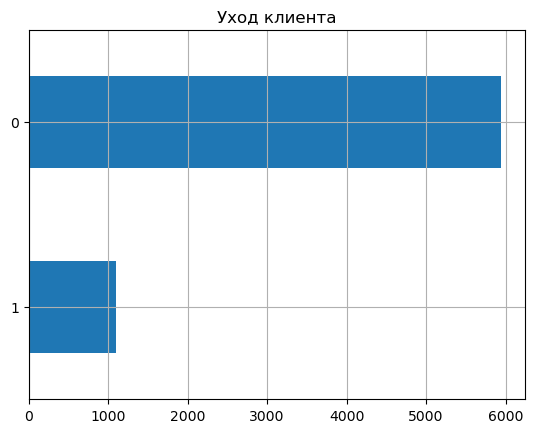

In [27]:
display_bar('leaving', 'Отвал', contract_data, target=True)

Присутствует классовый дисбаланс: на каждого отвалившегося клиента есть почти 6 действующих: Из 7 клиентов отваливается только 1.

#### Тип оплаты

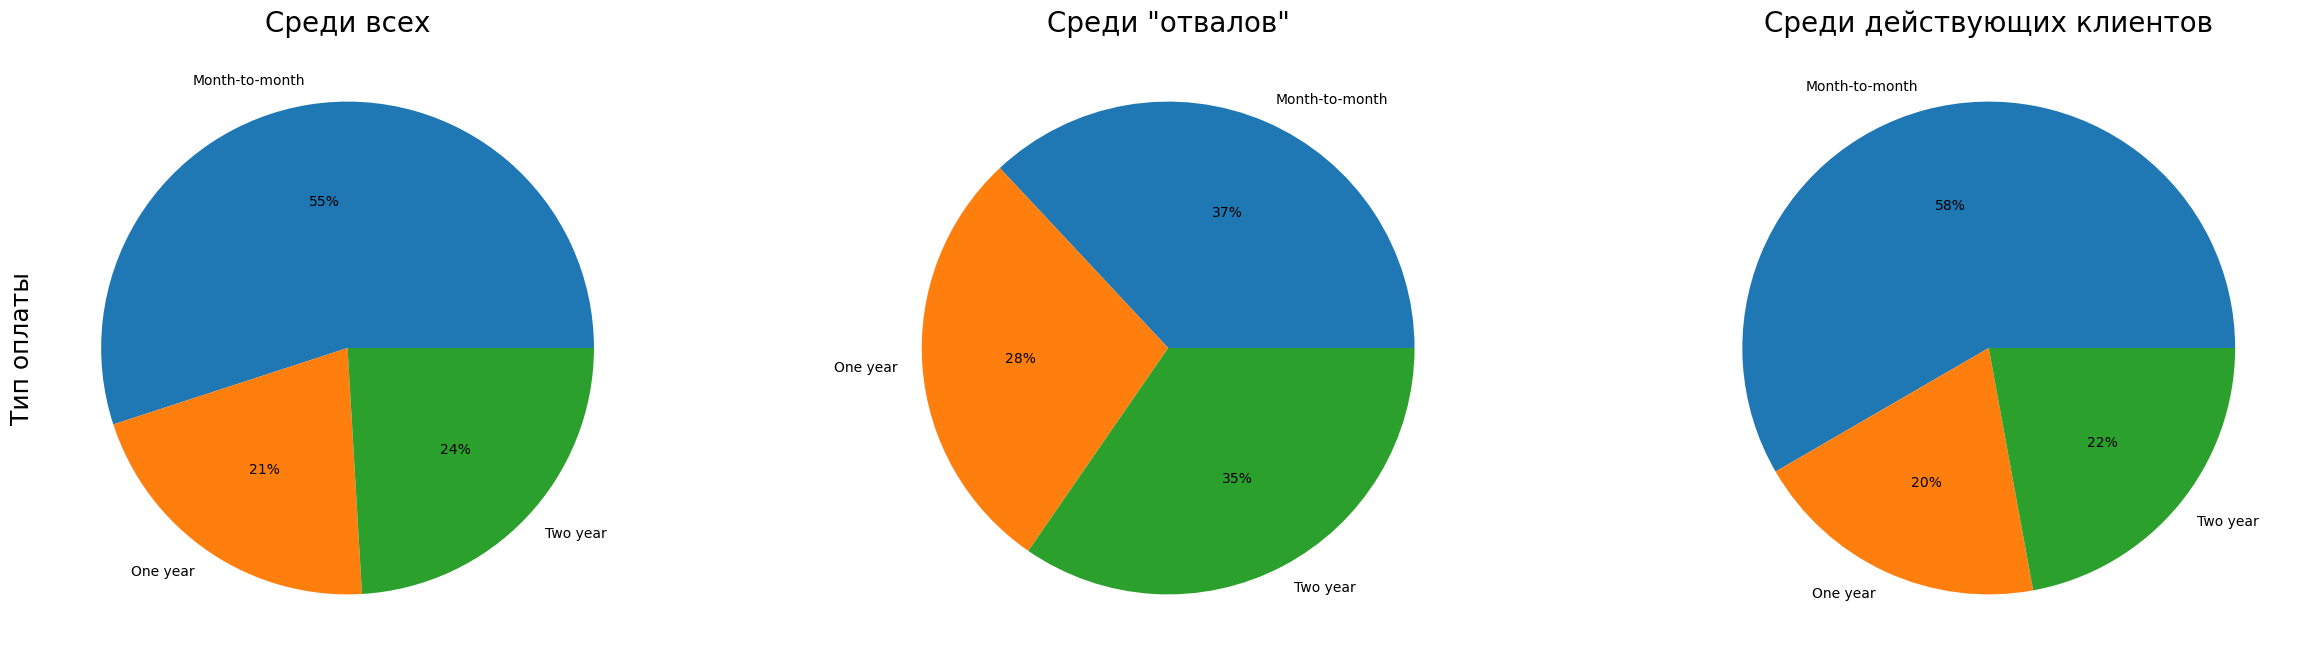

In [28]:
display_pie_chart('type', 'Тип оплаты', contract_data)

Среди действующих клиентов распределение такое же, как среди всех (больше половины помесячно, по 20 с небольшим процентов ежегодно и раз в 2 года). Среди отвалов - примерно одинаковое количество пользователей с каждым типом оплаты (37% помесячно, 35% раз в два года и 28% раз в год), это означает, что в среднем пользователи с оплатой раз в год или раз в два года могут отваливаться чаще, чем с помесячной.

#### Получение электронного чека

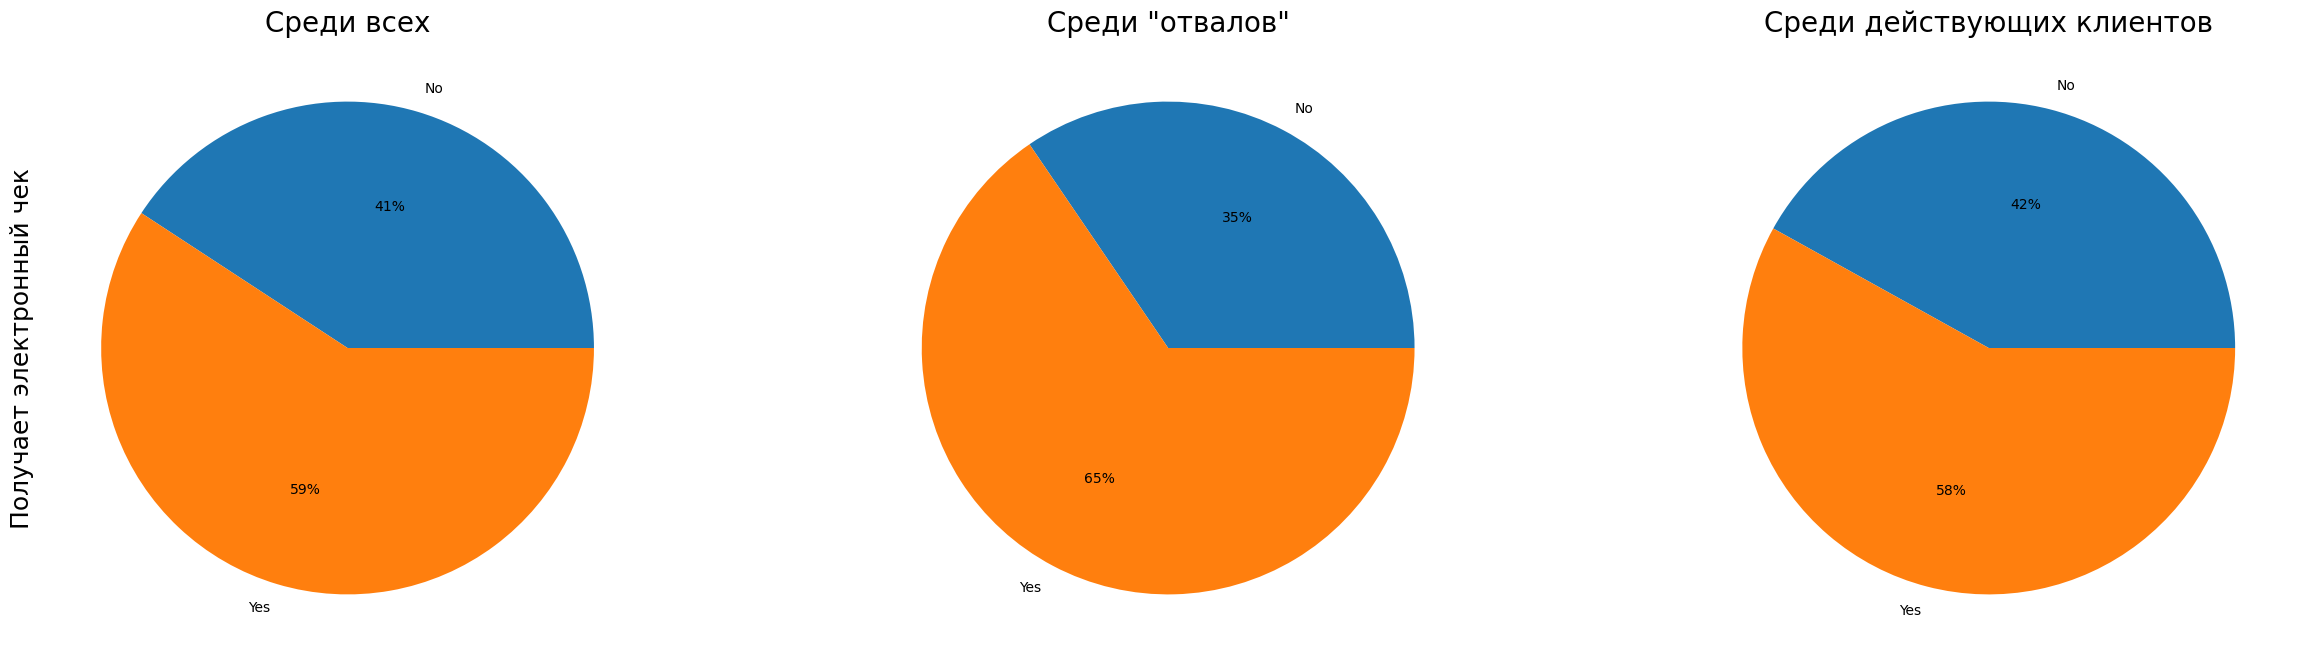

In [29]:
display_pie_chart('paperless_billing', 'Получает электронный чек', contract_data)

Среди всех клиентов и среди действующих электронный чек получает примерно 58-59% клиентов, а среди отвалов - 65%. То есть, клиенты с электронным чеком могут чуть отказываться от услуг.

#### Метод оплаты

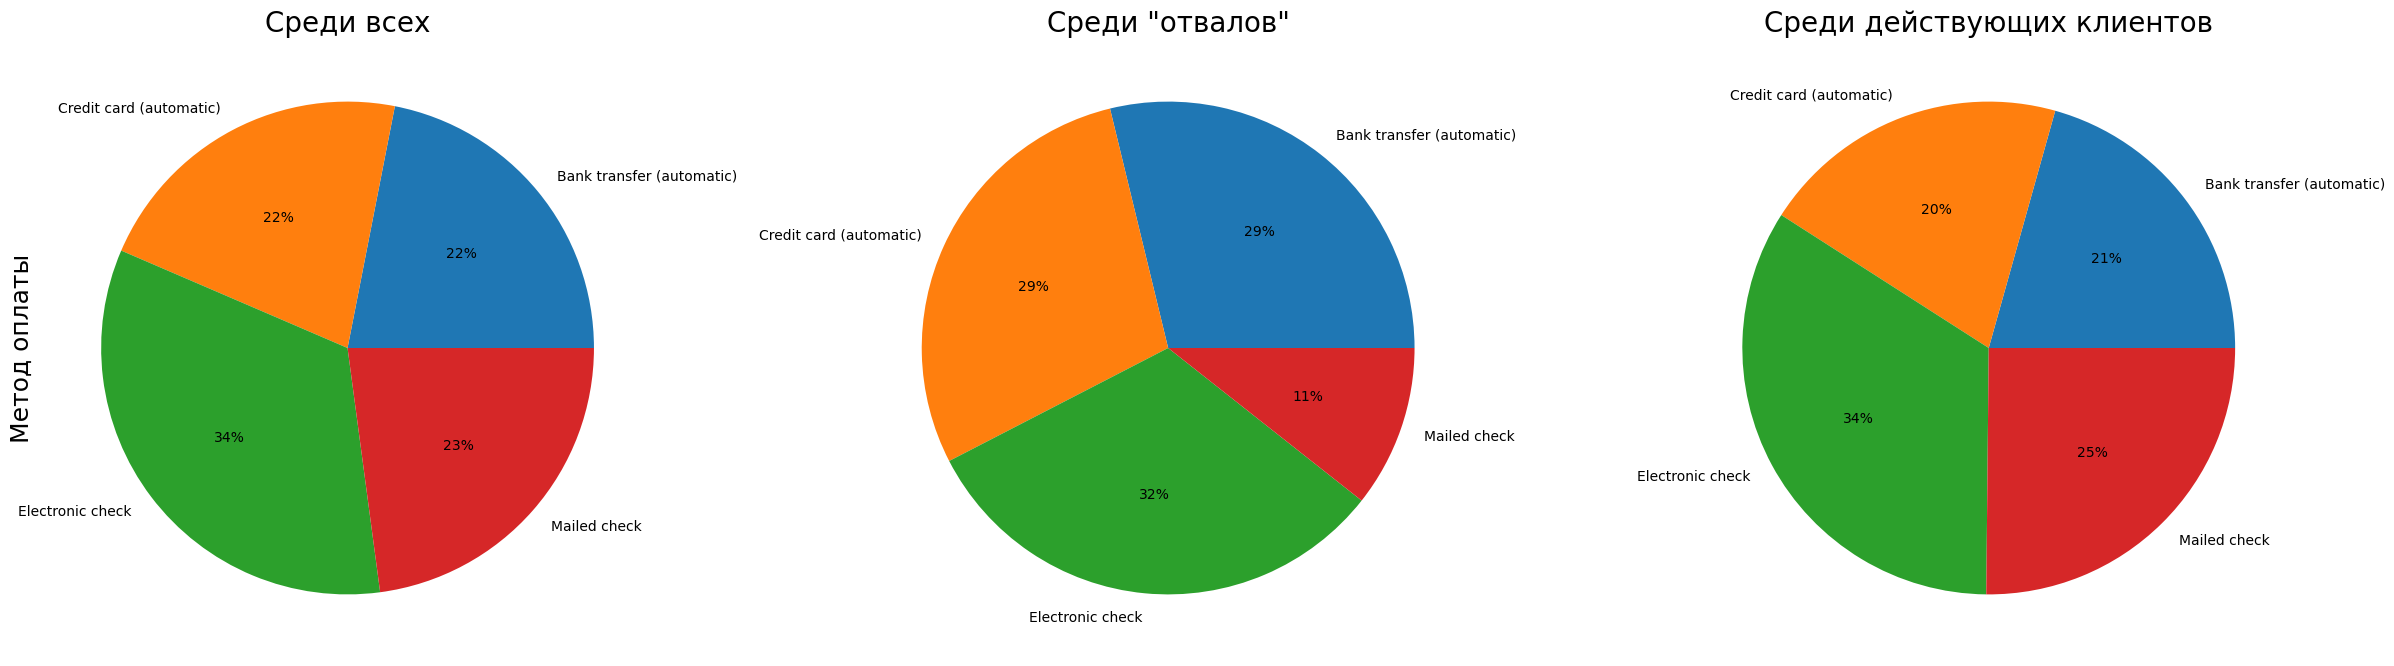

In [30]:
display_pie_chart('payment_method', 'Метод оплаты', contract_data)

Среди всех групп клиентов самый популярный способ - электронный чек (32% среди отвалов и 34% среди всех и действующих), далее следом среди всех и действующих идут примерно наравне по 22% счет на почту, автоплатеж с кредитки и через банк, а среди "отвалов" превалируют над оплатой через счет на почту (11%), после электронного счета клиенты с автоплатежом с карты и через банк (по 29%)

#### Расходы в месяц

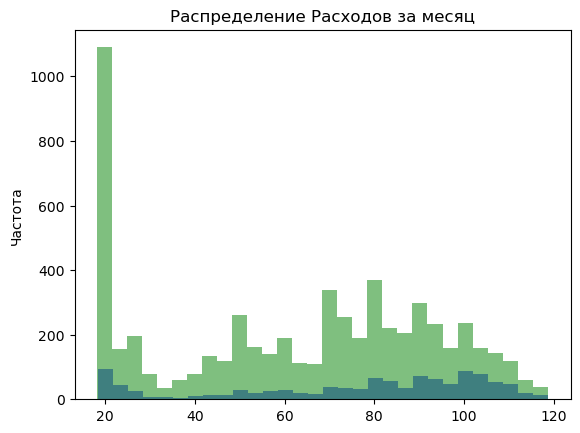

Общее: count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64 

Среди "отвалов": count    1101.000000
mean       75.546004
std        29.116213
min        18.400000
25%        56.150000
50%        84.200000
75%        99.500000
max       118.750000
Name: monthly_charges, dtype: float64 

Среди действующих: count    5942.000000
mean       62.763455
std        29.844462
min        18.250000
25%        30.062500
50%        69.200000
75%        87.237500
max       118.600000
Name: monthly_charges, dtype: float64 



In [31]:
display_hist('monthly_charges', 'Расходов за месяц', contract_data)

Распределения по форме примерно похожи среди всех трех обозреваемых групп, не имеют форму нормального. Наибольшее количество клиентов (около 15%) за месяц тратят 18.25 рублей, предполагаем, что это минимальный месячный тариф у заказчика. Остальные данные распределены мультимодально (50, 70, 80, 90) отдаленно напоминающе сильно сжатое нормальное распределение со средним около 70.

Обратим внимание, что медианный и средний чек месячных расходов у ушедших клиентов чуть выше, чем у действующих (среднее 75 против 62, медиана 84 против 70), а также у отвалившихся клиентов месячные расходы выше чем у действующих на всех уровнях (относительная частота корзин с бóльшими расходами у отвалившихся выше, чем у действующих). Для сравнения средних будем использовать правосторонний t-test для независимых выборок.

In [32]:
# Уровень значимости
alpha = 0.05
class_1 = contract_data[contract_data['leaving'] == 1]
class_0 = contract_data[contract_data['leaving'] == 0]
p_value = st.ttest_ind(class_1['monthly_charges'], class_0['monthly_charges'], alternative='greater').pvalue
print(p_value < alpha)

True


Можем отвергнуть нулевую гипотезу о равенстве средних в пользу правосторонней альтернативной.

#### Общая сумма расходов

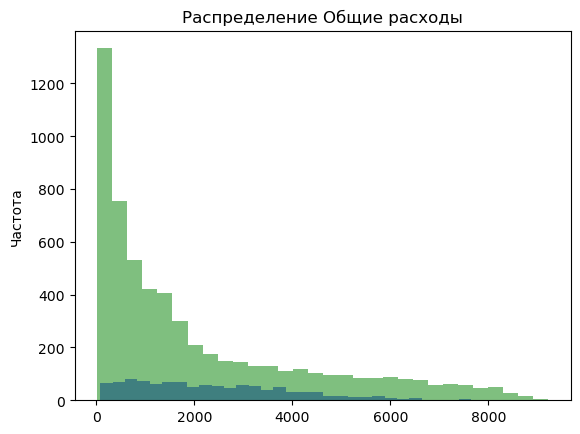

Общее: count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64 

Среди "отвалов": count    1101.000000
mean     2371.377275
std      1581.862275
min        77.840000
25%      1048.050000
50%      2139.030000
75%      3404.910000
max      7649.760000
Name: total_charges, dtype: float64 

Среди действующих: count    5942.000000
mean     2067.943095
std      2193.827140
min        19.050000
25%       374.352500
50%      1192.800000
75%      3173.837500
max      9221.380000
Name: total_charges, dtype: float64 



In [33]:
display_hist('total_charges', 'Общие расходы', contract_data)

Распределение общих расходов не имеет форму нормального: чем меньше сумма, тем больше частота. Присутствует значительный пик в около 19 на графиках среди всех и действующих клиентов.

Обратим внимание, что среди отвалившихся клиентов нет тех, чьи общие расходы меньше 77. Помимо этого, среднее (на 10%) и медиана (почти вдвое) среди отвалившихся больше, стандартное отклонение меньше почти на 25%, это говорит о большей однородности данных. Далее сравним средние с помощью правостороннего t-test.

In [34]:
p_value = st.ttest_ind(class_1['total_charges'], class_0['total_charges'], alternative='greater').pvalue
print(p_value < alpha)

True


### Объединенные данные

Объединим данные по ключу и изучим распределения новых признаков.

#### Личная информация
Так как в personal_data столько же строк, как и в contract_data, мы не получим новых пропущенных значений.

In [35]:
final_data = contract_data.merge(personal_data, on='customer_id', how='left')

#### Пол

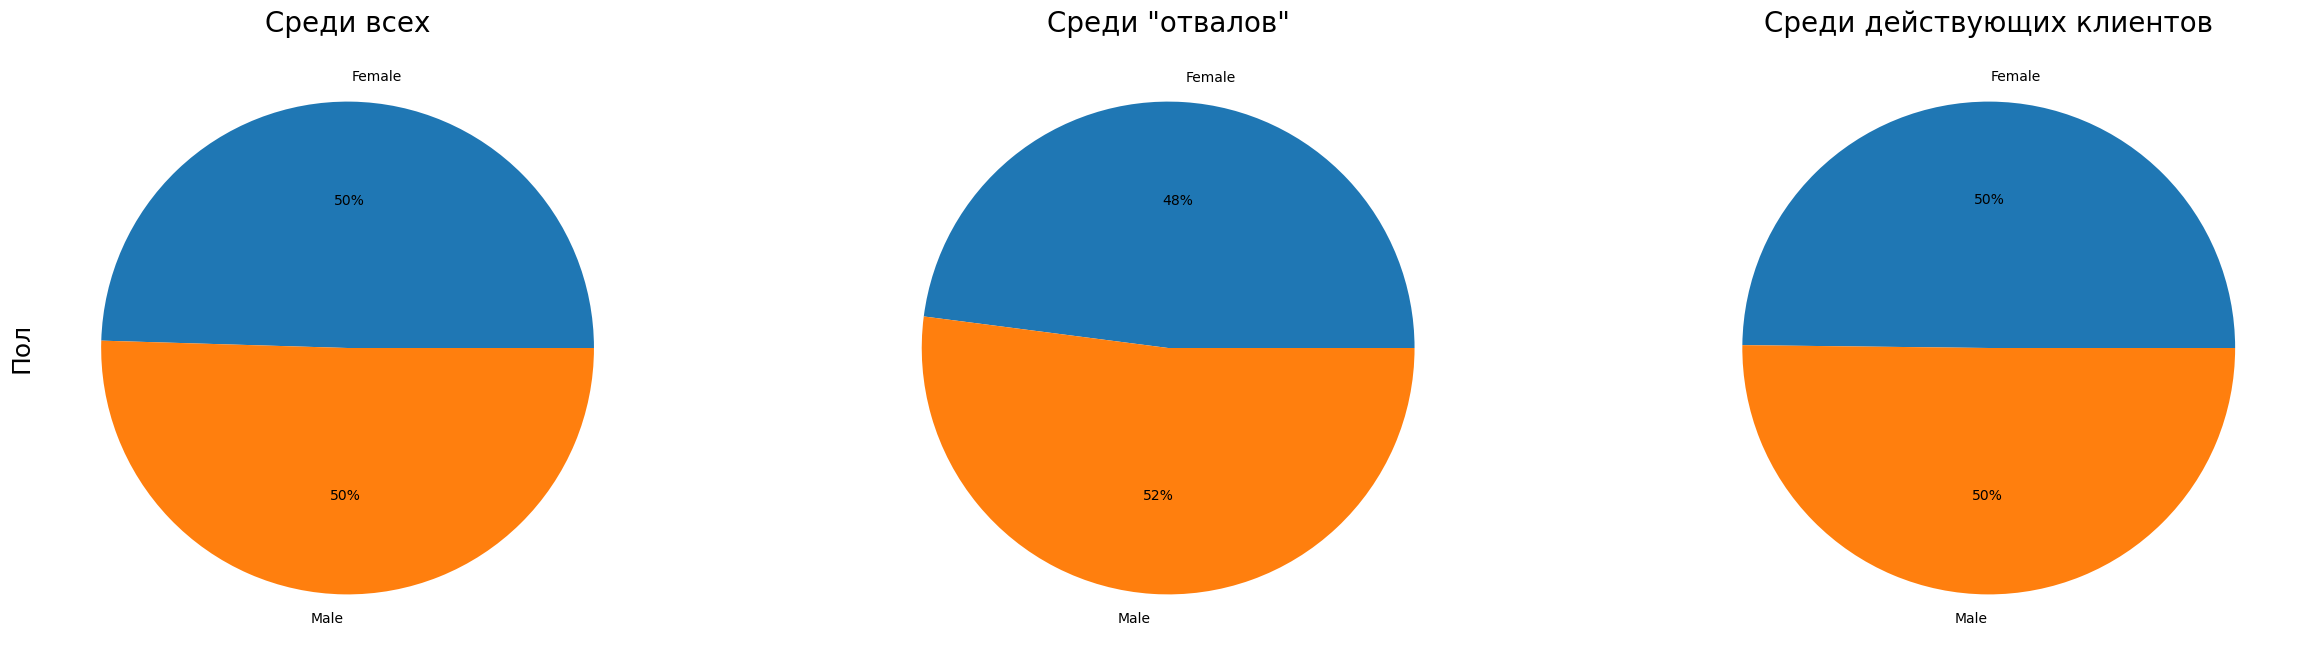

In [36]:
display_pie_chart('gender', 'Пол', final_data)

Среди всех данных и среди действующих клиентов распределение пола примерно пополам, а среди отвалов на 4% больше мужчин.

#### Пенсионный возраст

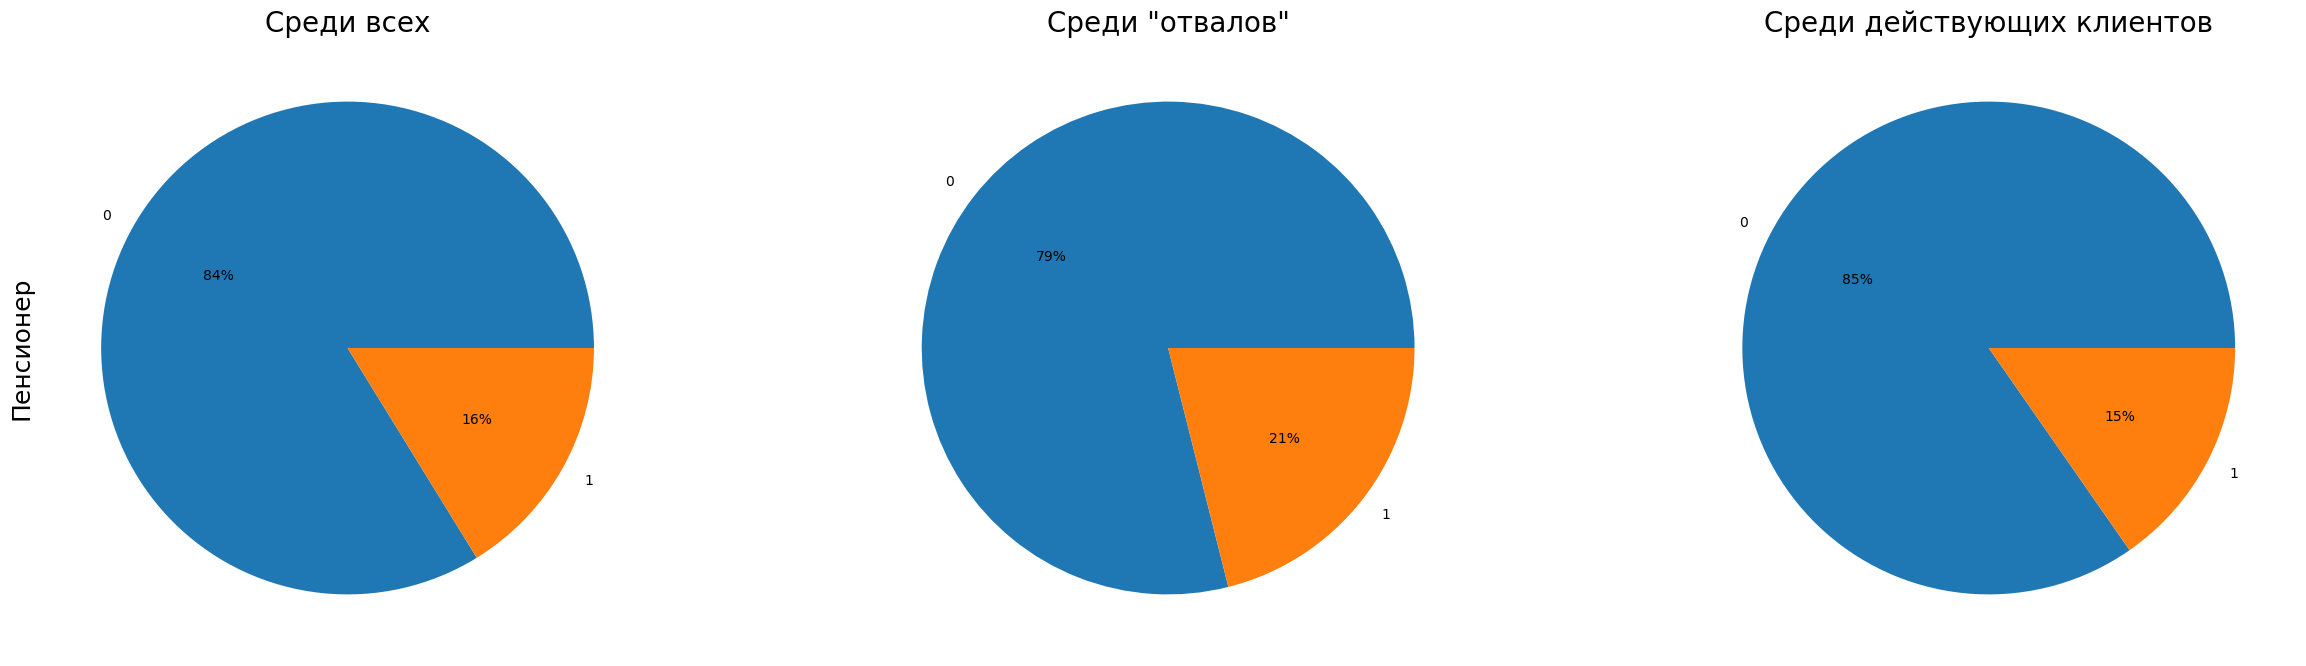

In [37]:
display_pie_chart('senior_citizen', 'Пенсионер', final_data)

Среди всех и среди действующих клиентов пенсионеры только 15%, а среди отвалов - 21%.

#### Замужество

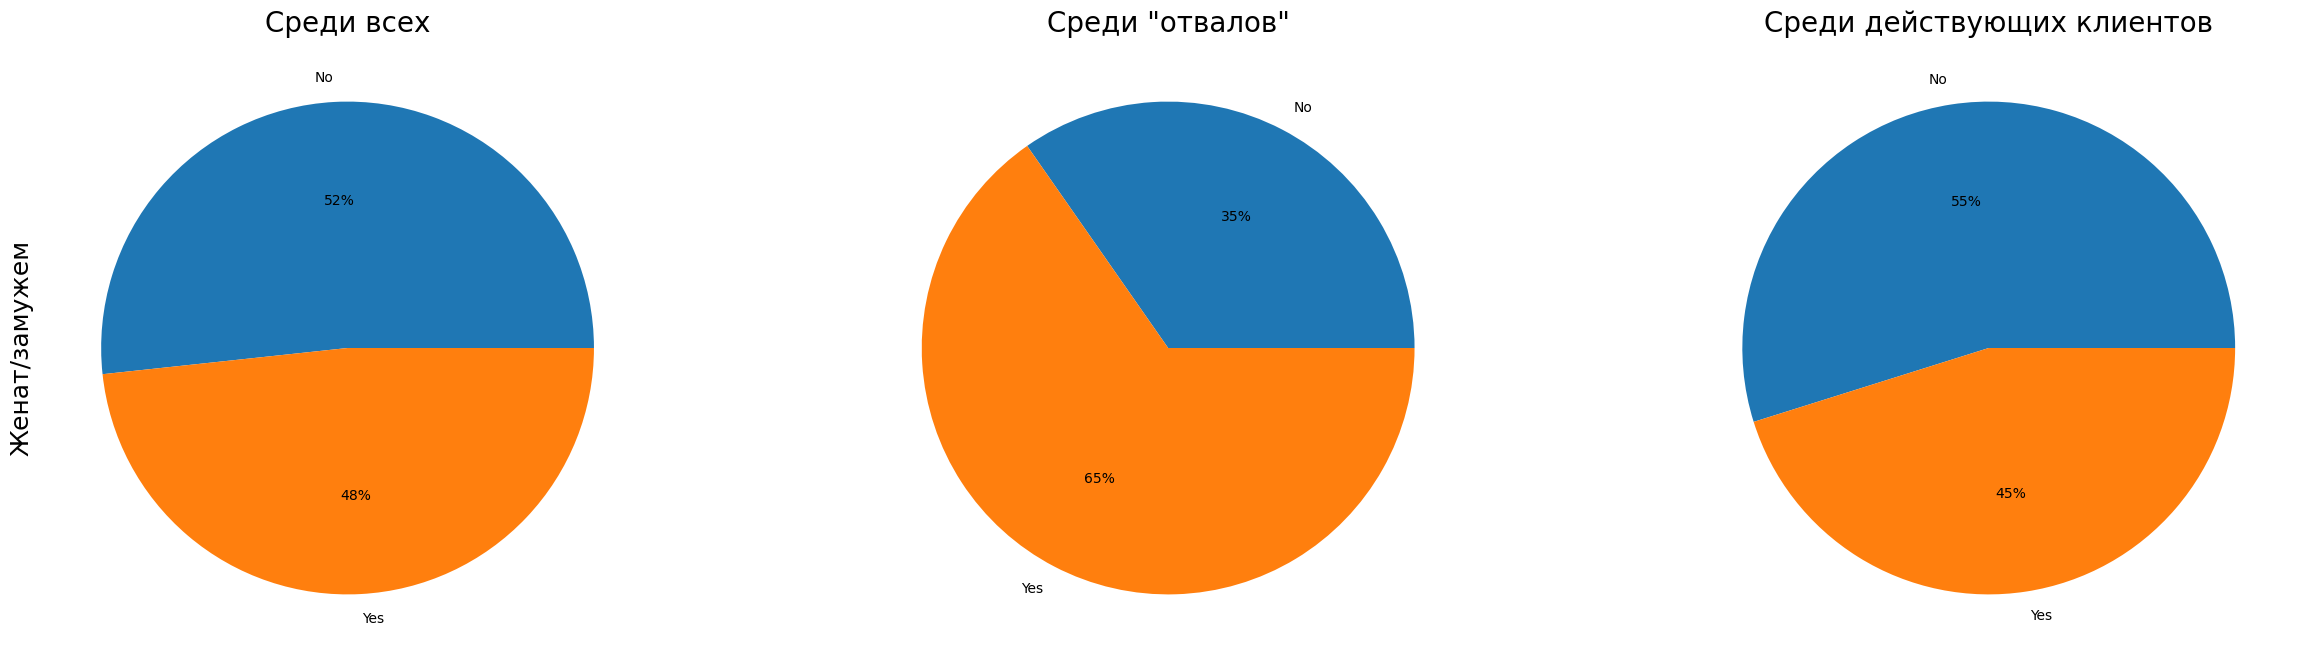

In [38]:
display_pie_chart('partner', 'Женат/замужем', final_data)

Среди действующих клиентов больше неженатых/не замужем (55%), а среди отвалов 65% женатые/замужем.

#### Наличие детей

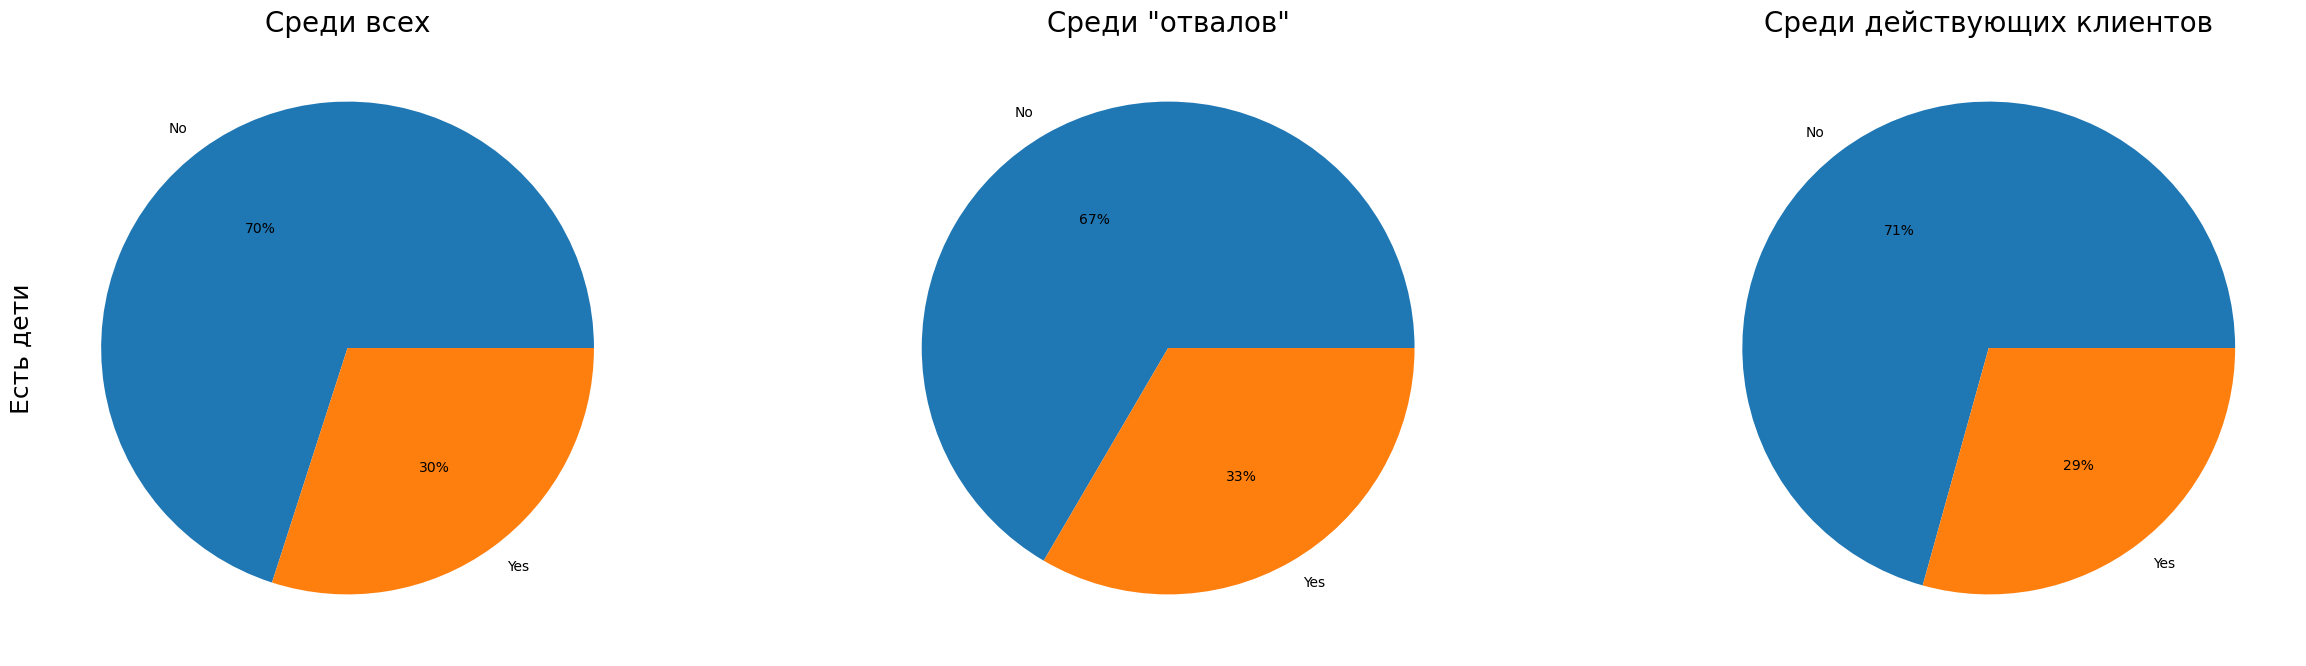

In [39]:
display_pie_chart('dependents', 'Есть дети', final_data)

Около 69% действующих клиентов не имеют детей, в то время как среди отвалов таких 67%. 

#### Информация об интернет-услугах
Присоединим таблицу internet_data к final_data и посмотрим, появились ли пропуки.

In [40]:
final_data = final_data.merge(internet_data, on='customer_id', how='left')
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   leaving            7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

У нас есть данные только о подключенных интернет-услугах 5517 клиентов, а не 7043. Предполагаем, что это клиенты компании, которые пользуются только услугами связи, а интернетом не пользуются. Заполним эти пропуски заглушкой "нет интернета", так как это позволит нам оценить процентное соотношение среди пользователей, у которых подключен интернет, а также проанализировать, влияет ли конкретная услуга на вероятность отвала: так как мы можем сложить доли у отсутствующей услуги и нашей заглушки.

In [41]:
final_data = final_data.fillna('No Internet')

#### Тип интернет-кабеля

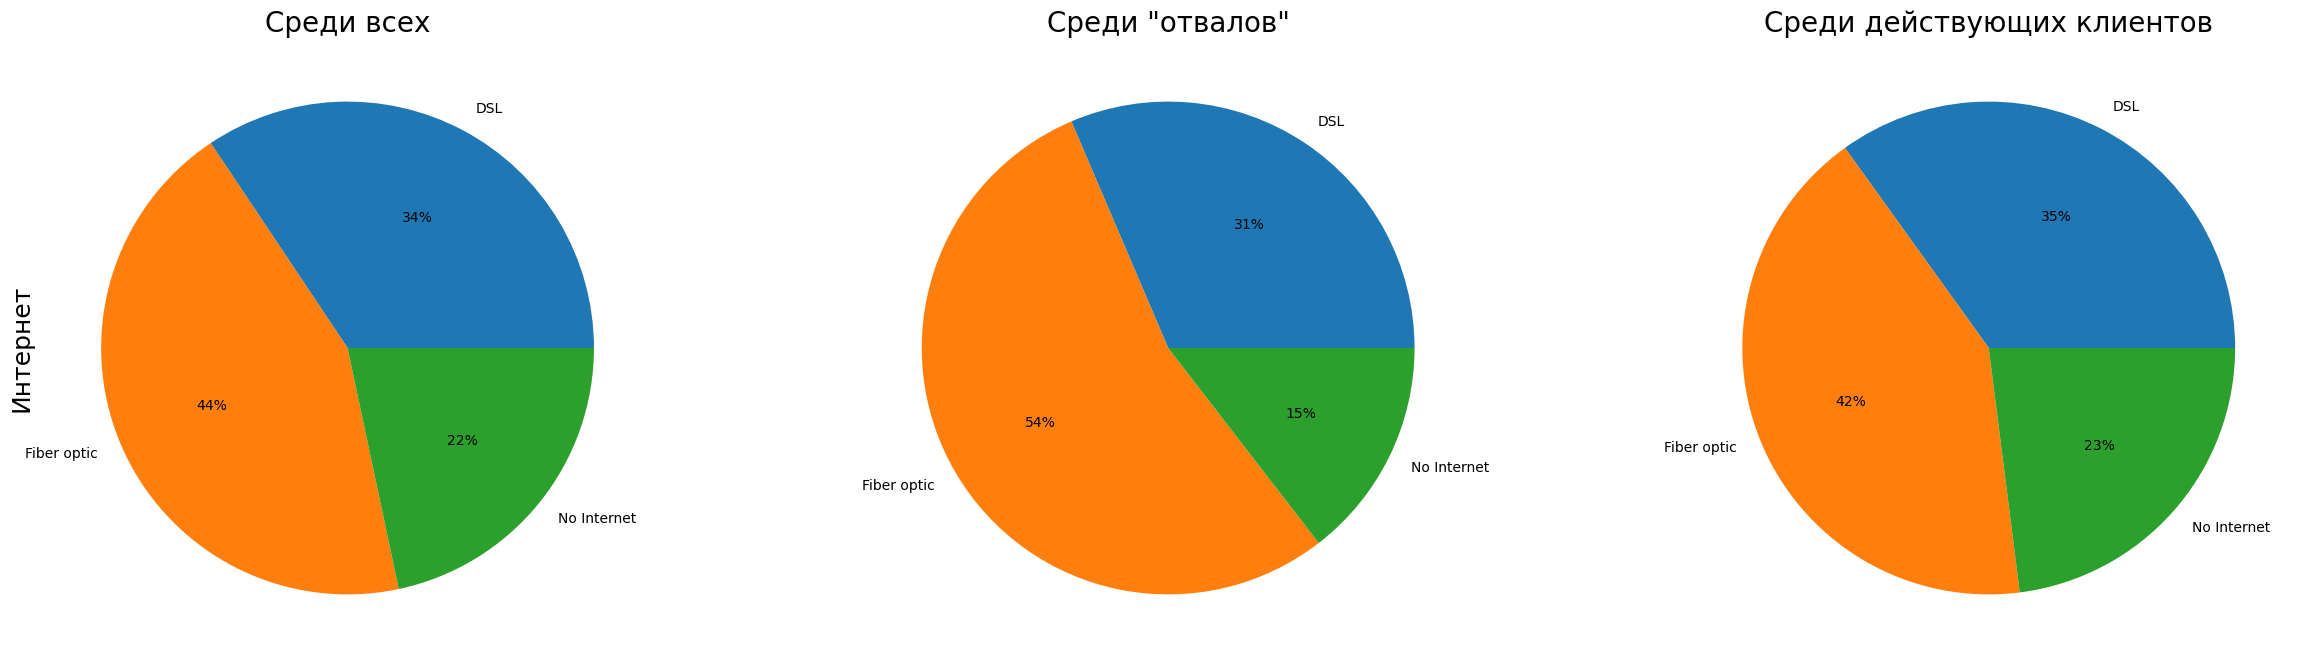

In [42]:
display_pie_chart('internet_service', 'Интернет', final_data)

Среди отвалов относительная частота оптоволоконного кабеля выше, чем среди действующих на 12% (54% против 42%).

#### Блокировка небезопасных сайтов

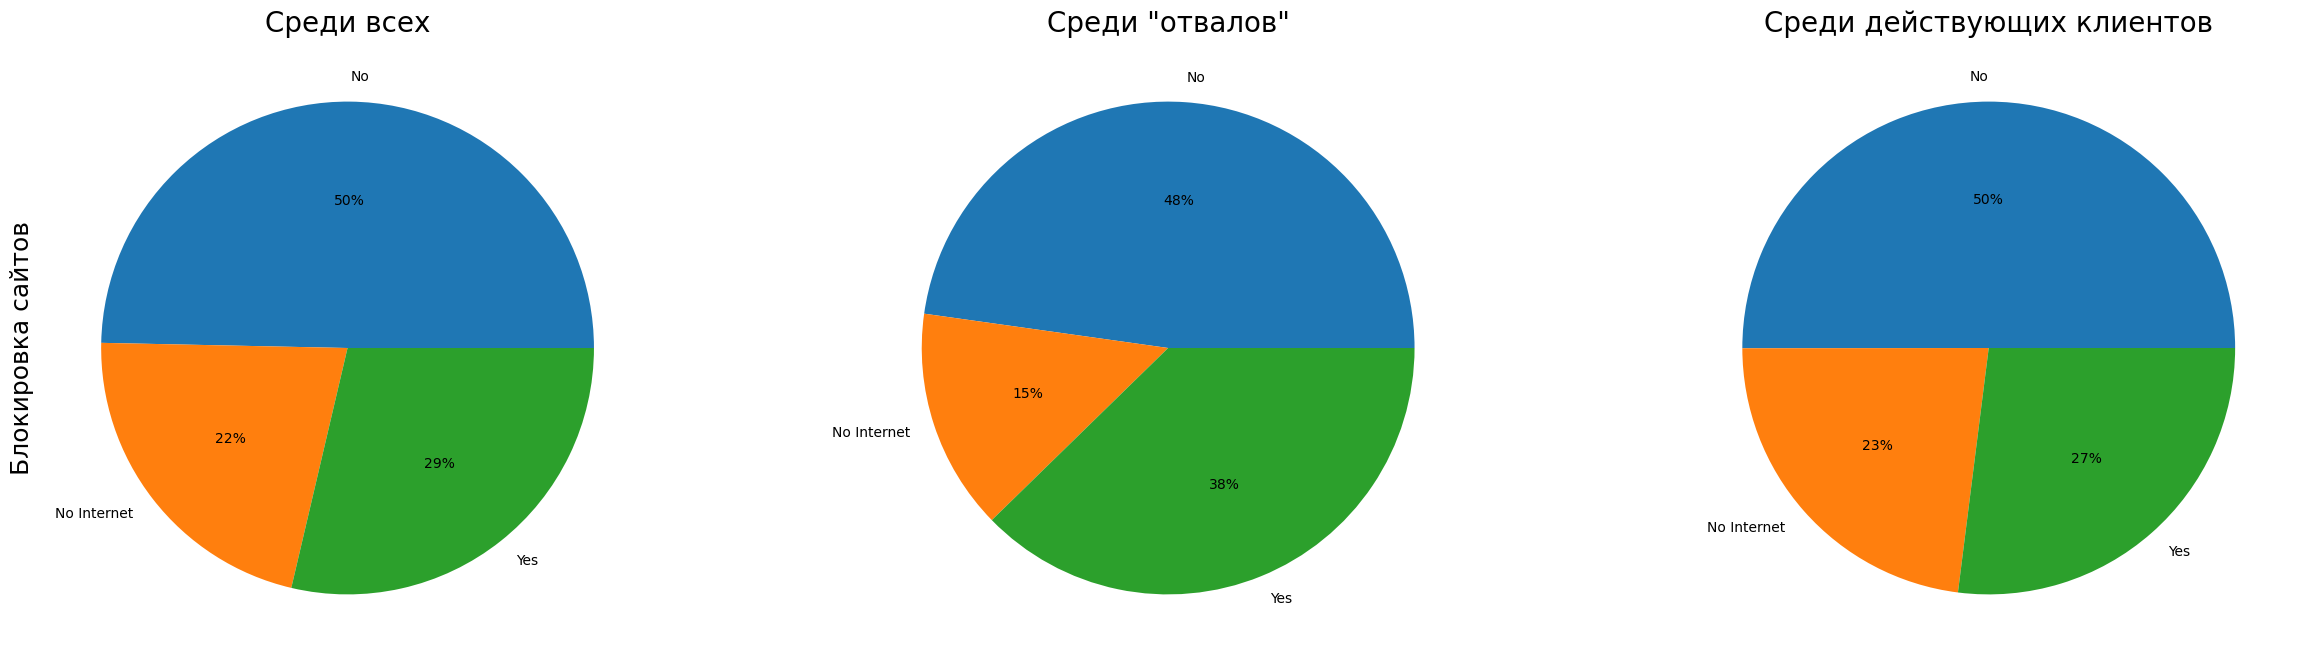

In [43]:
display_pie_chart('online_security', 'Блокировка сайтов', final_data)

Среди отвалов относительная частота использующих антивирус на 11% выше, чем среди действующих клиентов, при том почти такой же процент тех, кто не пользуется сервисом.

#### Резервное копирование

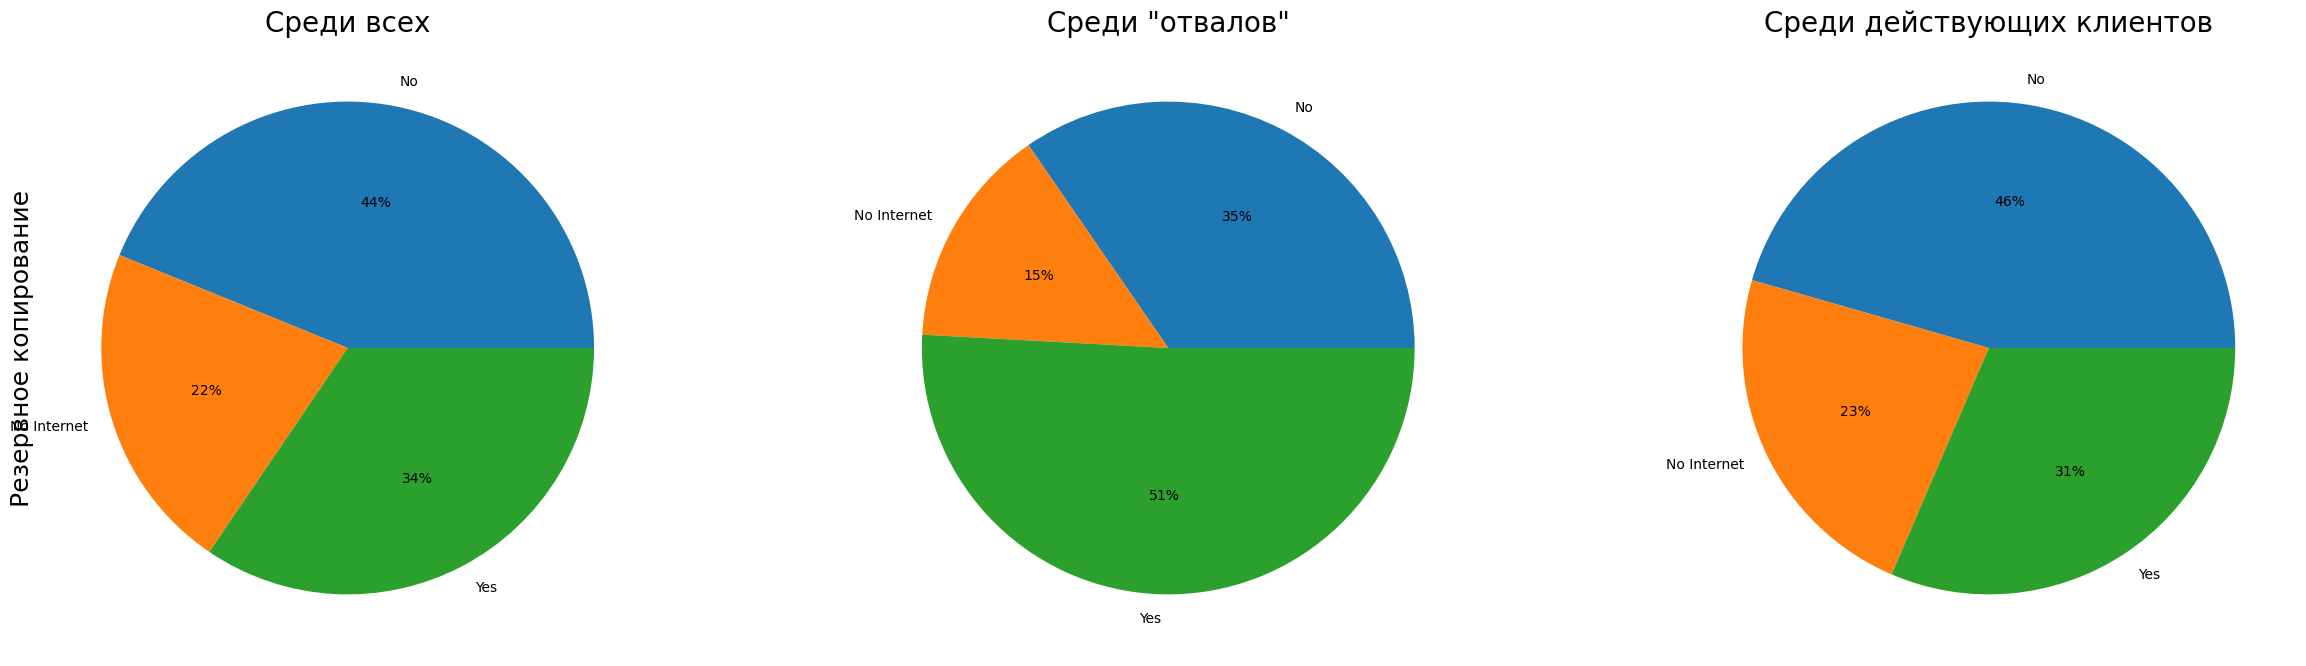

In [44]:
display_pie_chart('online_backup', 'Резервное копирование', final_data)

Среди отвалов на 20% больше пользователей с сервисом резервного копирования, процент не пользующихся среди отвалов меньше. Использование этого сервиса может влиять на вероятность отвала.

#### Антивирус

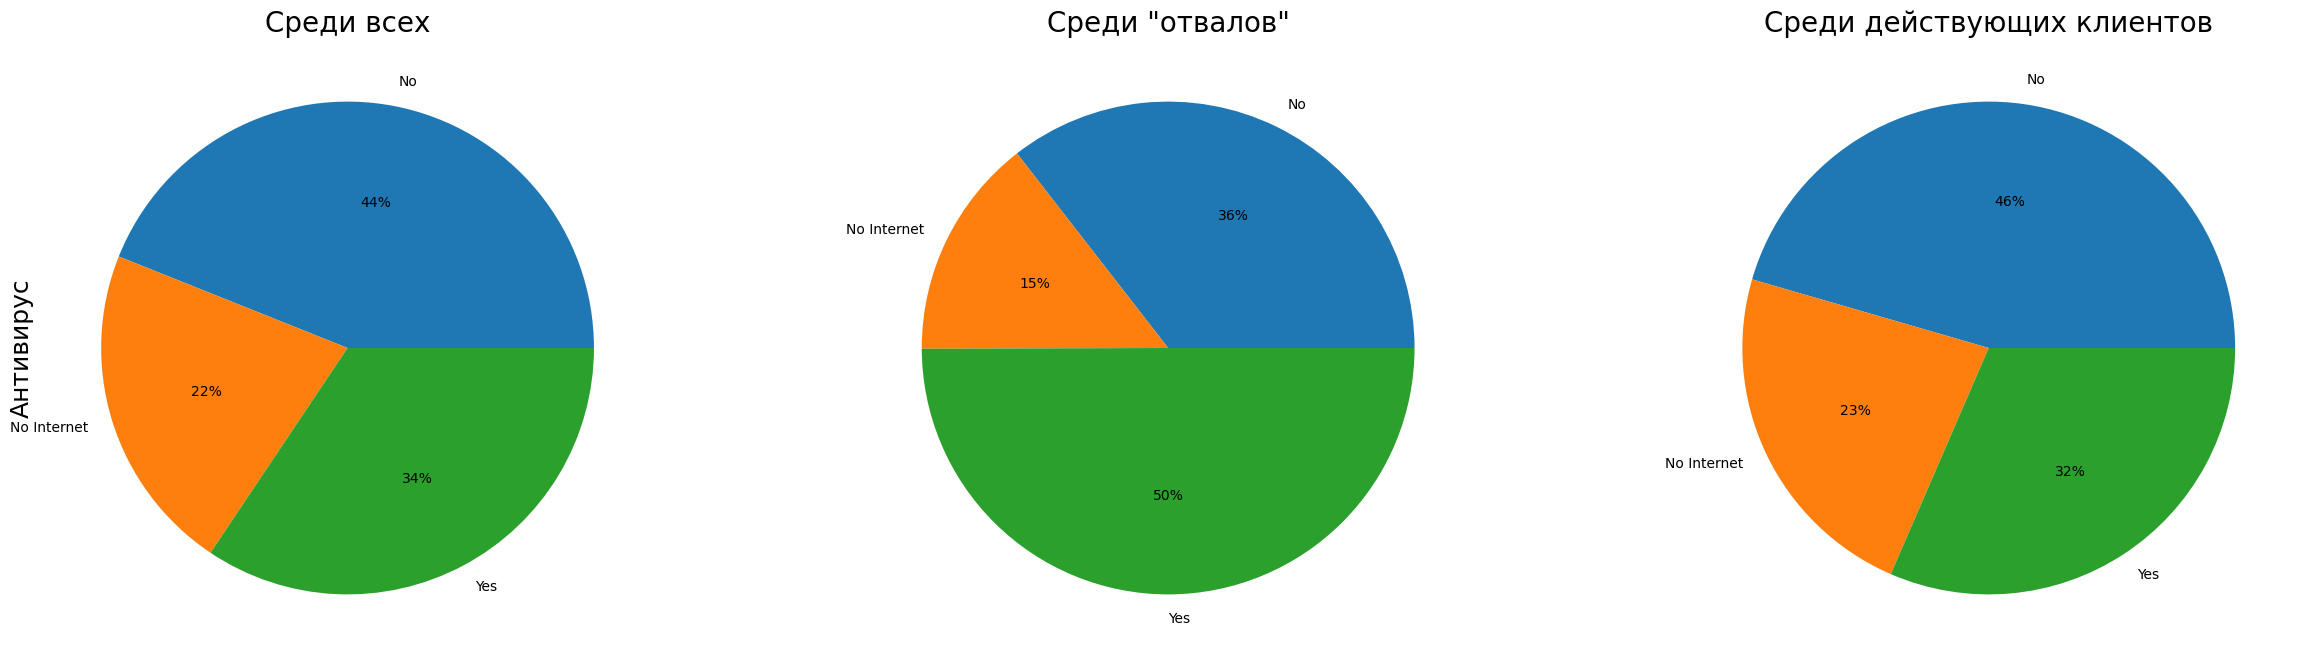

In [45]:
display_pie_chart('device_protection', 'Антивирус', final_data)

Среди отвалов половина использует антивирус, а не использующих меньше на 10%, чем у действующих. Использование сервиса может влиять на вероятность отвала.

#### Техническая поддержка

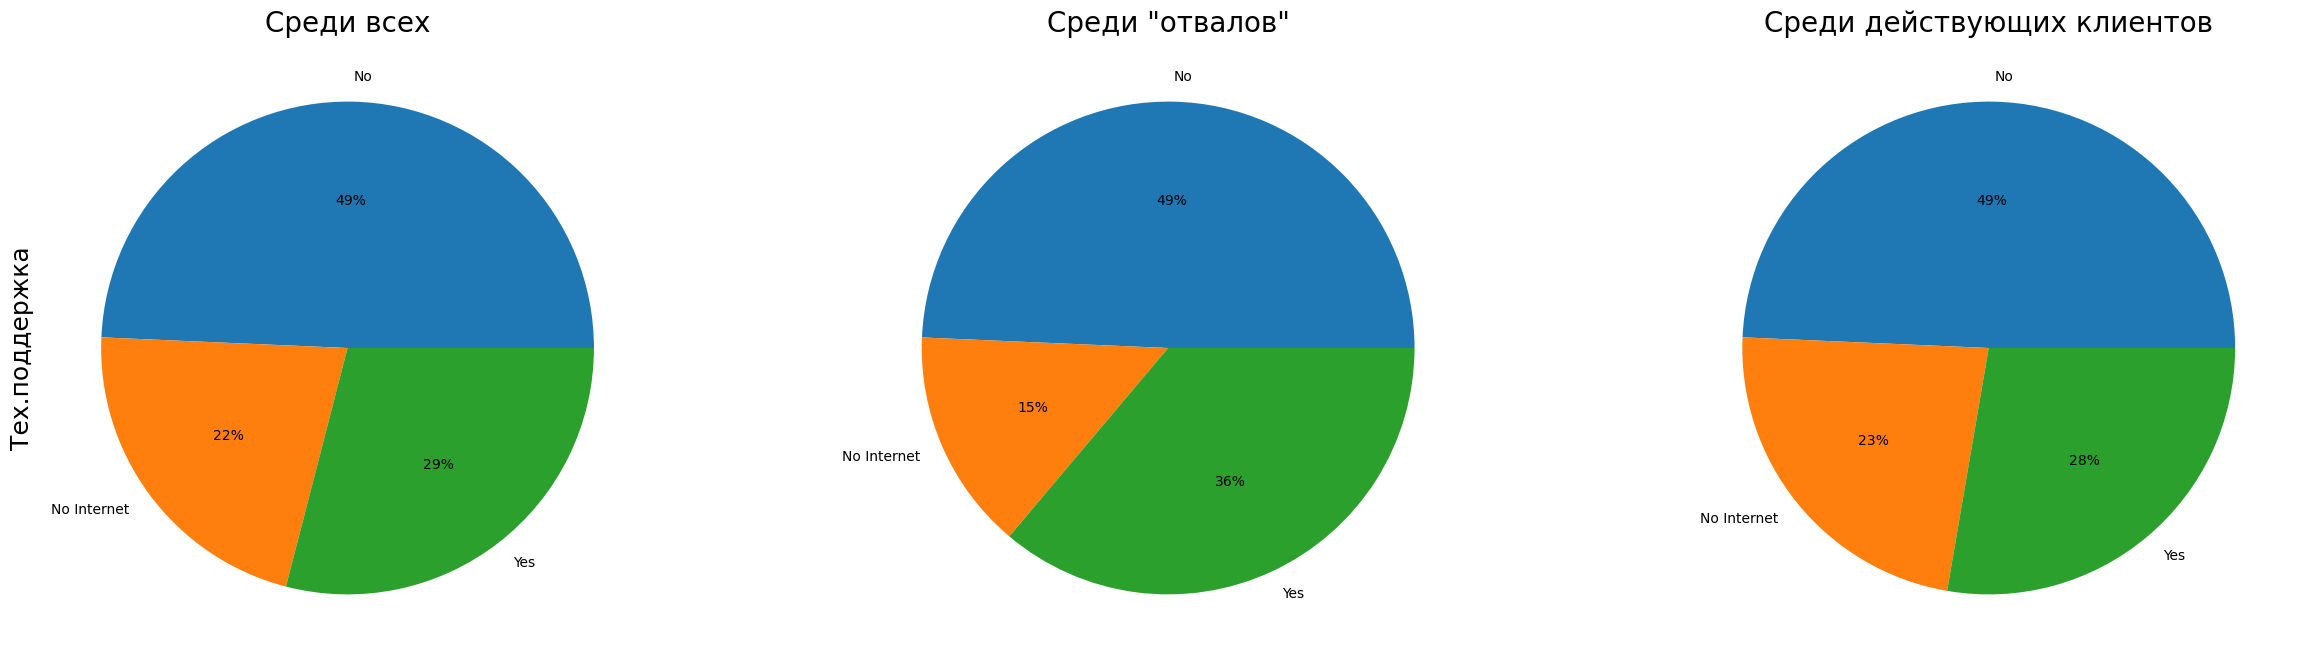

In [46]:
display_pie_chart('tech_support', 'Тех.поддержка', final_data)

Среди отвалов такой же процент тех, кто не использует сервис, а процент использующих сервис выше, это не озанчает, что использование сервиса влияет на вероятность отвала.

#### Стриминговое телевидение

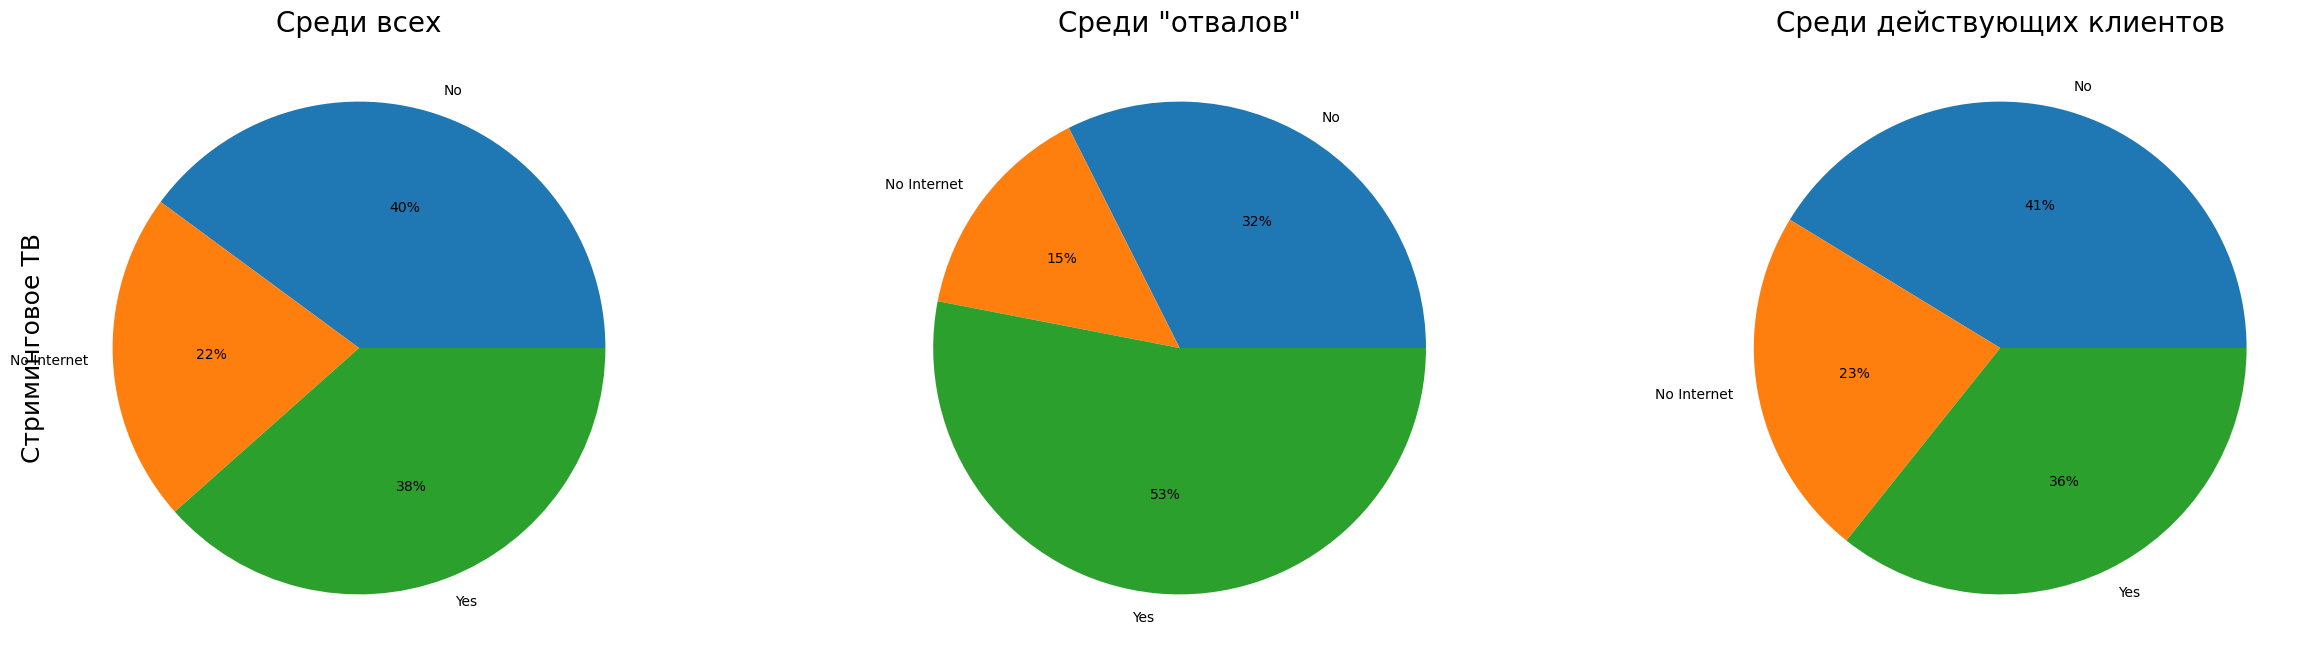

In [47]:
display_pie_chart('streaming_tv', 'Стриминговое ТВ', final_data)

Среди отвалов на 17% больше тех, кто пользуется сервисом. Использование сервиса может влиять на вероятность отвала.

#### Каталог фильмов

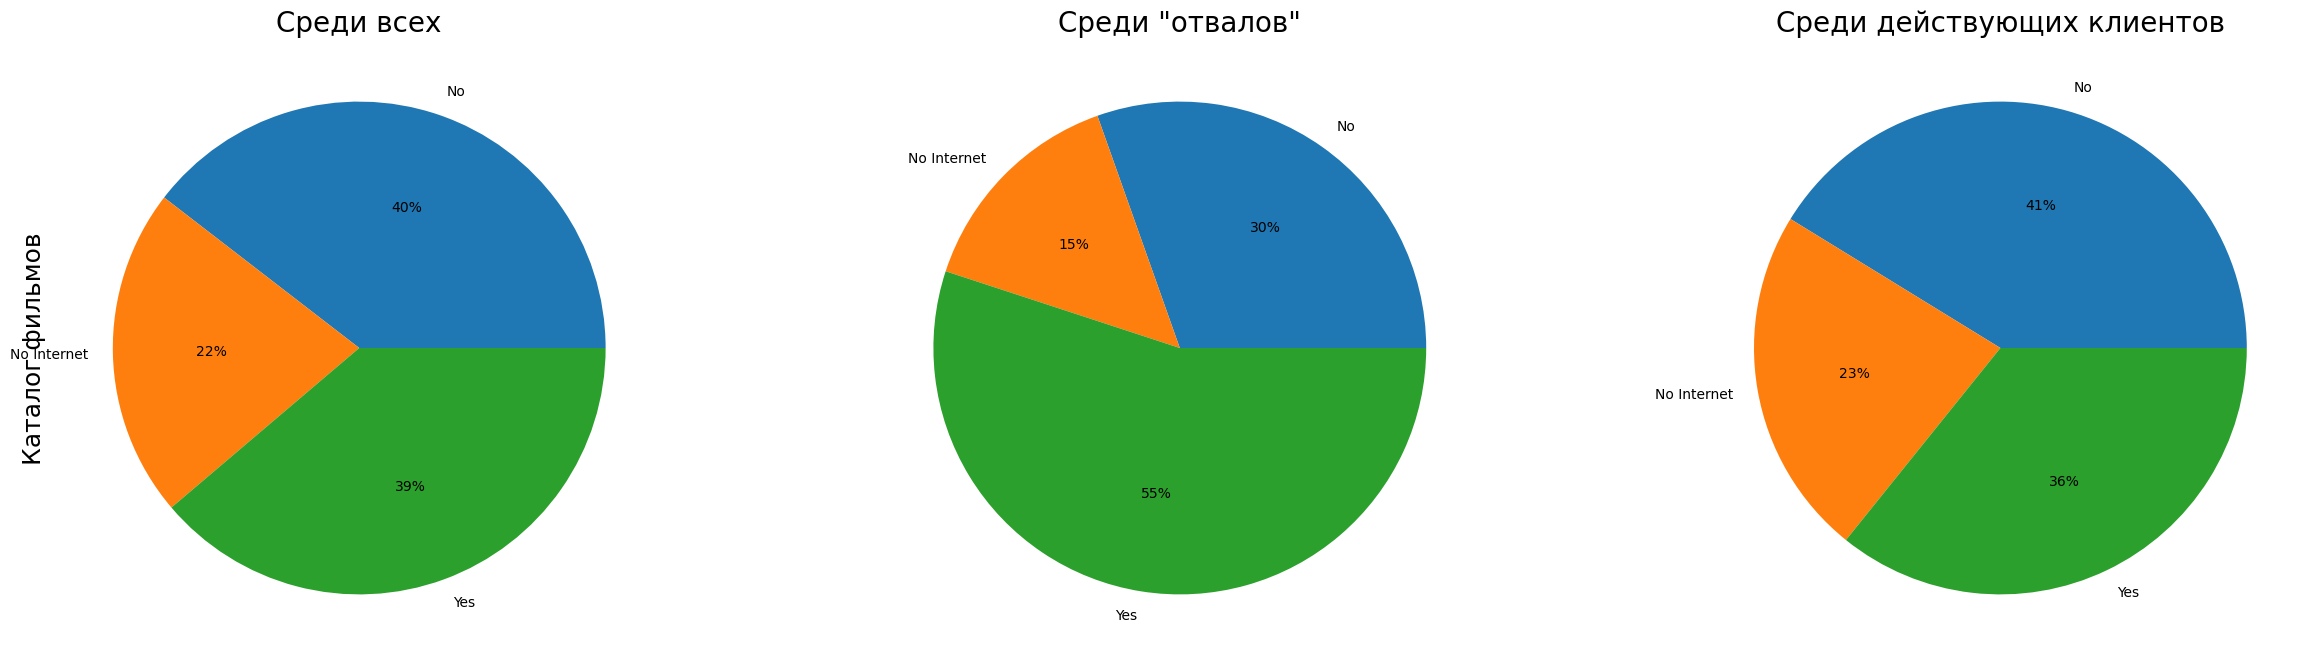

In [48]:
display_pie_chart('streaming_movies', 'Каталог фильмов', final_data)

Среди отвалов на 19% больше тех, кто пользуется сервисом. Использование сервиса может влиять на вероятность отвала.

#### Подключение телефона к нескольким линиям одновременно

In [49]:
final_data = final_data.merge(phone_data, on='customer_id', how='left')
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   leaving            7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

Присоединили последнюю таблицу. В `'multiple_lines'` 6361 не пустых значения. Предполагаем, что это пользователи, которые не пользуются телефоном, поэтому заполним эти пропуски заглушкой 'No phone'.

In [50]:
final_data = final_data.fillna('No phone')

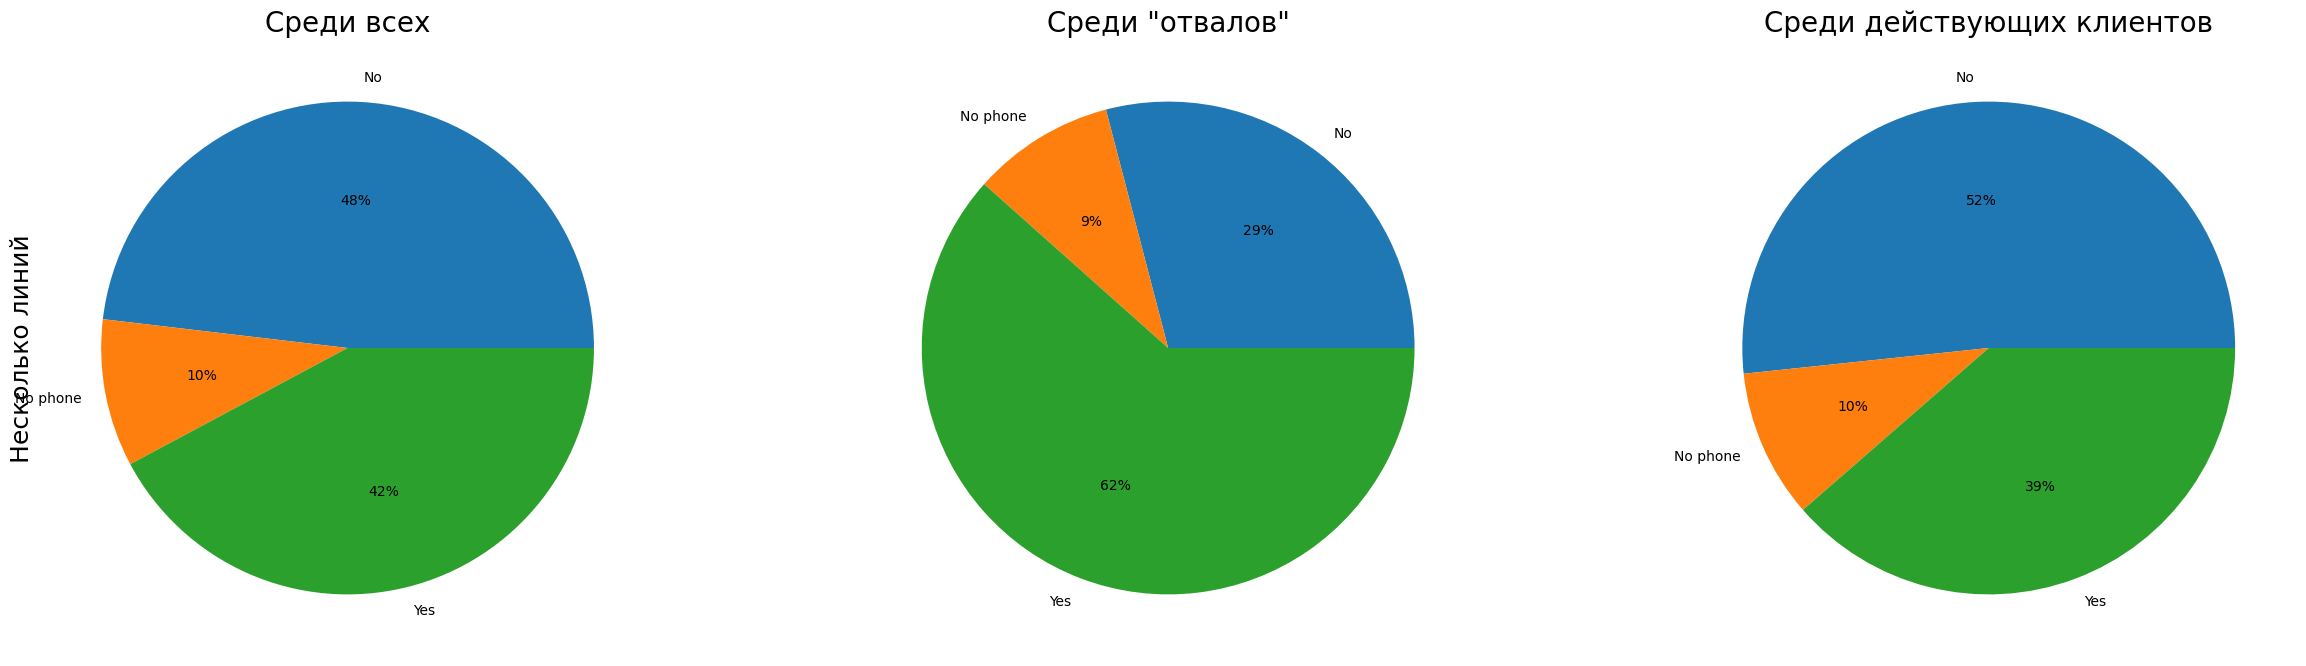

In [51]:
display_pie_chart('multiple_lines', 'Несколько линий', final_data)

Среди отвалов 62% использовали сервис, это на 23% больше, чем среди действующих. Использование сервиса может влиять на вероятность отвала.

### Корреляционный анализ данных
Для корреляционного анализа будем использовать phik, так как данные не имеют нормальное распределение.

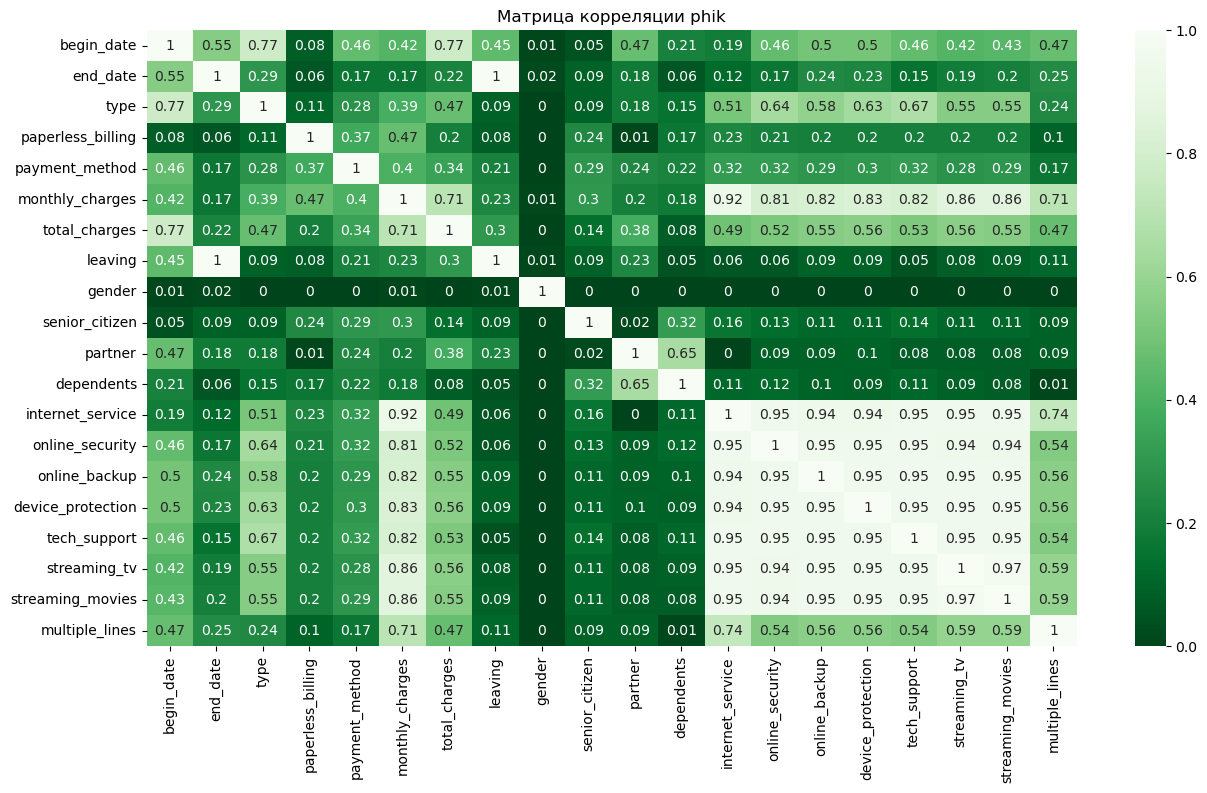

In [52]:
matrix = (final_data
          .drop('customer_id', axis=1)
          .phik_matrix(interval_cols=['monthly_charges', 'total_charges']).round(2))
plt.figure(figsize=(15,8))
sns.heatmap(data=matrix, annot=True, cmap='Greens_r')
plt.title('Матрица корреляции phik')
plt.show()

Из тепловой карты хорошо видно, что признаки наличия интернет-услуг сильно коррелируют друг с другом, почти не коррелируют с целевым признаком и значительно коррелируют с признаком месячные расходы, который влияет на целевой признак сильнее их всех. Поэтому принято решение удалить эти признаки, кроме одного - 'online_backup', так как он сильнее всего коррелирует с целевым и меньше коррелирует с месячными тратами. Также с этим признаком коррелирует почти не коррелирующий с целевым, признак тип интернет-кабеля. Его тоже удалим.

Также есть признак дата окончания договора, которые коррелирует с целевым с коэффициентом 1 - его мы удалим в следующем разделе, потому что в нем пока есть ценные для нас данные.

Признак пол не коррелирует с целевым, его также удалим.

In [53]:
final_data = final_data.drop(['online_security','device_protection',
                              'tech_support','streaming_tv',
                              'streaming_movies','internet_service', 'gender'], axis=1)

- Мультиколлинеарность: Тип интернет-кабеля в сильной зависимости с месячными расходами; дата окончания договора - с целевой переменной (и это объясняется тем, что целевой признак мы выделяли из даты окончания); использование интернет-сервисов сильно коррелирует друг с другом (каждый с каждым). Мультиколлинеарные признаки удалены.
- Неважные признаки: пол.
- Сильнее всего с целевым признаком коррелирует дата начала договора, далее постараемся создать на основе него сильный признак.

### Создание признаков
Сначала создадим признак "длительность договора" - 'days' и удалим даты начала и завершения договора, чтобы избежать переобучения.

In [54]:
# Обработка данных о датах
final_data.loc[final_data['end_date'] == 'No', 'end_date'] = '2020-02-01'
final_data['end_date'] = final_data['end_date'].apply(pd.to_datetime)
final_data['days'] = final_data['end_date'] - final_data['begin_date']
final_data['days'] = final_data['days'].dt.days
final_data = final_data.drop(['begin_date', 'end_date'], axis=1)

In [55]:
#Код ментора
final_data.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,leaving,senior_citizen,partner,dependents,online_backup,multiple_lines,days
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,0,Yes,No,Yes,No phone,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,0,No,No,No,No,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,0,No,No,Yes,No,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,0,No,No,No,No phone,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,0,No,No,No,No,153


#### Длительность договора

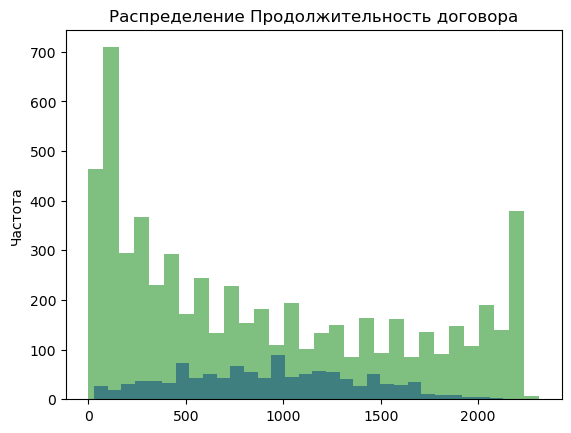

Общее: count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: days, dtype: float64 

Среди "отвалов": count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: days, dtype: float64 

Среди действующих: count    5942.000000
mean      893.681084
std       716.958551
min         0.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: days, dtype: float64 



In [56]:
display_hist('days', 'Продолжительность договора', final_data)

Распределение среди действующих не нормальное. Присутствует пик около 200 и 2200: это новые клиенты и большое количество "постоянников". Среди "отвалов" распределение похоже на нормальное со средним 924.

#### Корреляционный анализ (после создания)

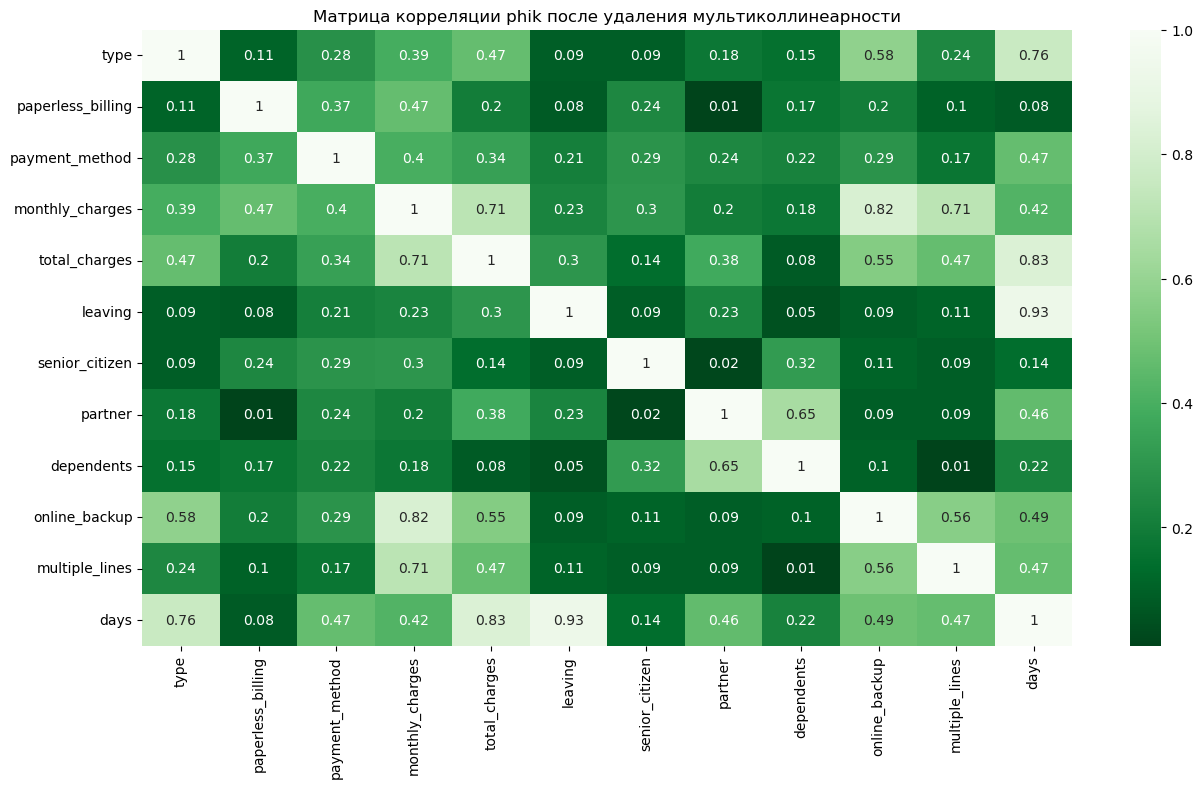

In [57]:
matrix = (final_data
          .drop('customer_id', axis=1)
          .phik_matrix(interval_cols=['monthly_charges', 'total_charges']).round(2))
plt.figure(figsize=(15,8))
sns.heatmap(data=matrix, annot=True, cmap='Greens_r')
plt.title('Матрица корреляции phik после удаления мультиколлинеарности')
plt.show()

### Выводы по EDA
#### Анализ данных
- Целевой признак "отвал": Присутствует классовый дисбаланс: на каждого отвалившегося клиента есть почти 6 действующих: Из 7 клиентов отваливается только 1.
- Расходы в месяц: Распределения по форме примерно похожи среди всех трех обозреваемых групп, не имеют форму нормального. Наибольшее количество клиентов (около 15%) за месяц тратят 18.25 рублей, предполагаем, что это минимальный месячный тариф у заказчика. Остальные данные распределены мультимодально (50, 70, 80, 90) отдаленно напоминающе сильно сжатое нормальное распределение со средним около 70.
Обратили внимание, что медианный и средний чек месячных расходов у ушедших клиентов чуть выше, чем у действующих (среднее 75 против 62, медиана 84 против 70), а также у отвалившихся клиентов месячные расходы выше чем у действующих на всех уровнях (относительная частота корзин с бóльшими расходами у отвалившихся выше, чем у действующих). Гипотеза подтверждена статистически.
- Общие расходы: Распределение общих расходов не имеет форму нормального: чем меньше сумма, тем больше частота. Присутствует значительный пик в около 19 на графиках среди всех и действующих клиентов. Гипотеза подтверждена статистически.
Обратим внимание, что среди отвалившихся клиентов нет тех, чьи общие расходы меньше 77. Помимо этого, среднее (на 10%) и медиана (почти вдвое) среди отвалившихся больше, стандартное отклонение меньше почти на 25%, это говорит о большей однородности данных.
- Проведен анализ распределений категориальных признаков, выявлены предположения, что использование сервисов может влиять на вероятность того, что клиент может отвалиться. Эти предположения будут проверены после построения моделей МО и анализа важности признаков.

#### Создание признаков
- Создан новый признак - длительность договора (дней). Распределение среди действующих не нормальное. Присутствует пик около 200 и 2200: это новые клиенты и большое количество "постоянников". Среди "отвалов" распределение похоже на нормальное со средним 924.

#### Корреляционный анализ
- Мультиколлинеарность: Тип интернет-кабеля в сильной зависимости с месячными расходами; дата окончания договора - с целевой переменной (и это объясняется тем, что целевой признак мы выделяли из даты окончания); использование интернет-сервисов сильно коррелирует друг с другом (каждый с каждым);
- Сильнее всего с целевым признаком коррелирует дата начала договора и длительность договора. 

## Обучение моделей МО

Для обучения моделей и выбора лучших гиперпараметров будем использовать пайплайны.

### Построение моделей, подбор гиперпараметров

In [58]:
RANDOM_STATE = 240225

In [59]:
# Списки для хранения названий признаков
num_list = ['monthly_charges', 'total_charges', 'days']
cat_list = ['type','online_backup', 'payment_method',
            'multiple_lines', 'paperless_billing',
            'senior_citizen', 'partner','dependents']

In [60]:
# Разделение на выборки
final_data = final_data.set_index('customer_id')
X_train, X_test, y_train, y_test = train_test_split(
    final_data.drop('leaving', axis=1),
    final_data['leaving'],
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=final_data['leaving']
)

In [61]:
# Пайплайны для обучения моделей
# Кодирование для бустинга и деревянных моделей
ord_pipe = Pipeline(
    [
        ('ord', OrdinalEncoder(categories='auto'))
    ]
)

# Кодирование OHE для линейной модели
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first'))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_list),
        ('cat', ord_pipe, cat_list)
    ],
    remainder='passthrough'
)


final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [62]:
# Список гиперпараметров для перебора
params = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(3, 8),
        'models__min_samples_leaf': range(2, 7),
        'models__max_depth': range(2, 8)
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 3, 5, 10],
        'preprocessor__cat': [ohe_pipe]
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE,
                                      verbose=False, learning_rate=0.03,
                                      auto_class_weights='Balanced',
                                      l2_leaf_reg=0.1)],
        'models__max_depth': range(3, 7),
        'models__iterations': [3000, 4500]
    }
]

In [63]:
# Обучение моделей
search = RandomizedSearchCV(
    final_pipe,
    params,
    scoring='roc_auc',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=30
)

search.fit(X_train, y_train)
model = search.best_estimator_
print(f'ROC-AUC на кросс-валидации: {search.best_score_}')

ROC-AUC на кросс-валидации: 0.9096309673420073


In [64]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['monthly_charges',
                                                   'total_charges', 'days']),
                                                 ('cat',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder())]),
                                                  ['type', 'online_backup',
                                                   'payment_method',
                                                   'multiple_lines',
                                                   'paperless_billing',
                                                   'senior_citizen', 'partner',
                                                   'dependents'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x147719120>)])

Лучшая модель - CatBoostClassifier(learning_rate=0.03, leaf_reg=0.1, verbose=False, auto_class_weights='Balanced', max_depth=4, iterations=4500, random_state=240225).  Модель показывает отличный результат на кросс-валидации! Проверим ее на тестовой метрике.

### Проверка модели

In [65]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.9232374892940168

Модель не переобучена, метрика roc-auc на тестовой выборке 0.92. Результат отличный!

### Анализ важности признаков

Анализировать важность будем с помощью графика beeswarm библиотеки Шэпли.

PermutationExplainer explainer: 1001it [00:55, 15.41it/s]                       


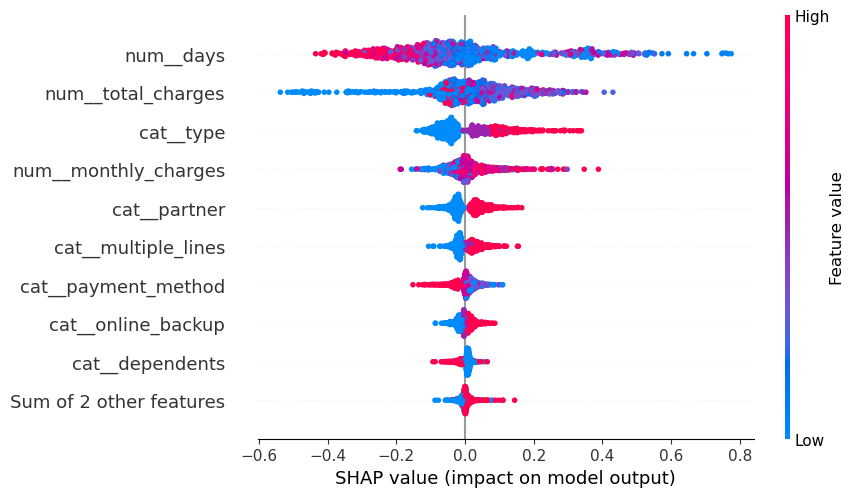

In [66]:
# Обработаем данные препроцессором лучшей модели
X_train_encoded = pd.DataFrame(data=model['preprocessor'].transform(
    X_train), columns=model['preprocessor'].get_feature_names_out())

explainer = shap.PermutationExplainer(
    model=model['models'].predict_proba,
    data=X_train_encoded,
    feature_name=model['preprocessor'].get_feature_names_out(),
    masker=shap.maskers.Independent(X_train_encoded)
)

# beeswarm построим на 1000 строк, чтобы не ждать долго
shap_values = explainer(shap.sample(X_train_encoded, 1000))
shap.plots.beeswarm(shap_values[:, :, 1])

С численными признаками все понятно, но чтобы расшифровать влияние категориальных, необходимо понять, как именно OrdinalEncoder закодировал наши признаки.

In [67]:
categories = (model
              .named_steps['preprocessor']
              .named_transformers_['cat']
              .named_steps['ord']
              .categories_)
for i in range(len(cat_list)):
    print(f'Признак: {(cat_list[i])}\nПорядок значений:{categories[i]}')
    print('')

Признак: type
Порядок значений:['Month-to-month' 'One year' 'Two year']

Признак: online_backup
Порядок значений:['No' 'No Internet' 'Yes']

Признак: payment_method
Порядок значений:['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']

Признак: multiple_lines
Порядок значений:['No' 'No phone' 'Yes']

Признак: paperless_billing
Порядок значений:['No' 'Yes']

Признак: senior_citizen
Порядок значений:[0 1]

Признак: partner
Порядок значений:['No' 'Yes']

Признак: dependents
Порядок значений:['No' 'Yes']



Теперь мы знаем, как пайплайн закодировал признаки, можно переходить к выводу.

#### Важность признаков
- Сильно на отвал влияет длительность договора: высокие и средние значения говорят о перевесе в сторону лояльности и не намекают на разрыв договора, в то время как более низкие значения сводят к тому, что клиент имеет риск отвалиться;
- Сильно влияет Тип оплаты: к отвалу значительно менее склонны оплачивающие помесячно и более склонны остальные, очень сильно склонны оплачивающие раз в 2 года;
- Клиенты с очень низкой или очень высокая сумма общих расходов менее склонны к отвалу (то есть новые клиенты и "звезды" по общей выручке), средние значения говорят о большей склонности к отвалу;
- Клиенты с низкими и средними месячными расходами менее склонны к отвалу, чем клиенты с высокими;
- Не женатые менее склонны к отвалу, чем женатые;
- Не пользующиеся сервисом с параллельными линиями менее склонные к отвалу;
- Клиенты, получающие счет на почту, менее всех склонны к отвалу;
- Клиенты с детьми менее склонны к отвалу.

#### Отбор признаков
Удалим три самых неважных признака - пенсионер по возрасту, подключение сервиса онлайн-бэкап и получение не бумажного чека и изучим метрики.

In [68]:
# Списки для хранения названий признаков (обновленные)
num_list = ['monthly_charges', 'total_charges', 'days']
cat_list = ['type', 'payment_method', 'multiple_lines', 'partner', 'dependents']

# Удаление неважных признаков
final_data = final_data.drop(['senior_citizen', 'paperless_billing', 'online_backup'], axis=1)

# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(
    final_data.drop('leaving', axis=1),
    final_data['leaving'],
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=final_data['leaving']
)

In [69]:
# Заново обучим модель
ord_pipe_final = Pipeline(
    [
        ('ord', OrdinalEncoder(categories='auto'))
    ]
)

data_preprocessor_final = ColumnTransformer(
    [
        ('num', StandardScaler(), num_list),
        ('cat', ord_pipe_final, cat_list)
    ],
    remainder='passthrough'
)

# Конфигурация лучшей модели сохранена
final_model = Pipeline(
    [
        ('preprocessor', data_preprocessor_final),
        ('models', CatBoostClassifier(random_state=RANDOM_STATE,
                                      learning_rate=0.03,
                                      auto_class_weights='Balanced',
                                      iterations=4500,
                                      l2_leaf_reg=0.1,
                                      max_depth=4,
                                      verbose=False)
        )
    ]
)

final_model.fit(X_train, y_train)
print(f'ROC-AUC на кросс-валидации: {cross_val_score(final_model, X_train, y_train, cv=5, scoring="roc_auc").mean()}')

ROC-AUC на кросс-валидации: 0.9114100230254806


Модель чуть хуже на кросс-валидации, но стоит проверить ее на тестовой выборке, так как удаление признаков может устранить влияние шума на результаты модели.

### Проверка лучшей модели на тестовой выборке

In [70]:
print(f'ROC-AUC на тестовой выборке: {roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])}')
print(f'Accuracy (точность) на тестовой выборке: {accuracy_score(y_test, final_model.predict(X_test))}')

ROC-AUC на тестовой выборке: 0.927343692646519
Accuracy (точность) на тестовой выборке: 0.9063032367972743


ROC-AUC на тестовой выборке 0.92, Accuracy 0.9. Результат достойный.


#### Матрица ошибок

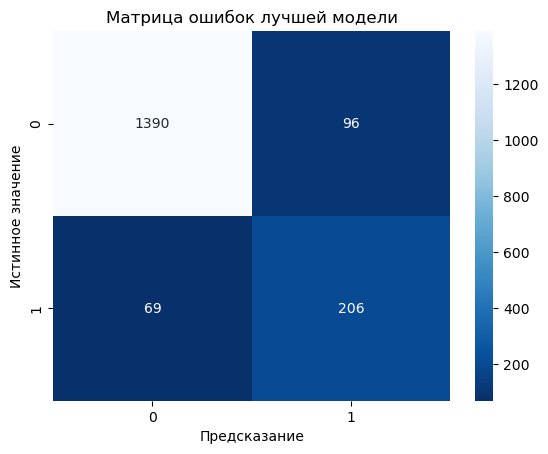

In [71]:
sns.heatmap(data=confusion_matrix(y_test, final_model.predict(X_test)), annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок лучшей модели')
plt.xlabel('Предсказание')
plt.ylabel('Истинное значение')
plt.show()

Модель почти не ошибается с предсказанием класса 1 - ошиблась 96 раз из почти 1500 объектов, но чуть чаще ошибается с предсказанием класса 0 - 69 ошибок из 275 объектов, но при учете классового дисбаланса результат хороший. К тому же, при необходимости можно отрегулировать порог классификации модели, если для заказчика не критично выдать промокод или скидку клиенту, который не склонен к отвалу, но это позволит добиться большей точности в оценке классом 1.

#### Кривая ROC
Для отчета также построим ROC-кривую лучшей модели.

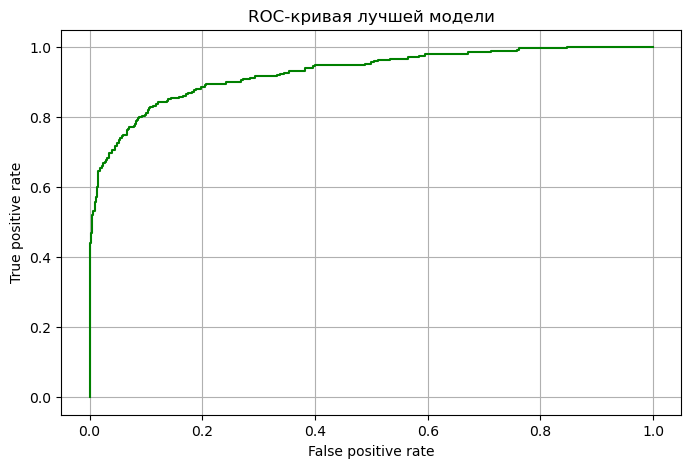

In [72]:
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, color='g')
plt.title('ROC-кривая лучшей модели')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid()
plt.show()

#### Матрица корреляции после отбора признаков
Для отчета выведем еще итоговую матрицу корреляции, в которую вошли только те признаки, которые были использованы при обучении лучшей модели.

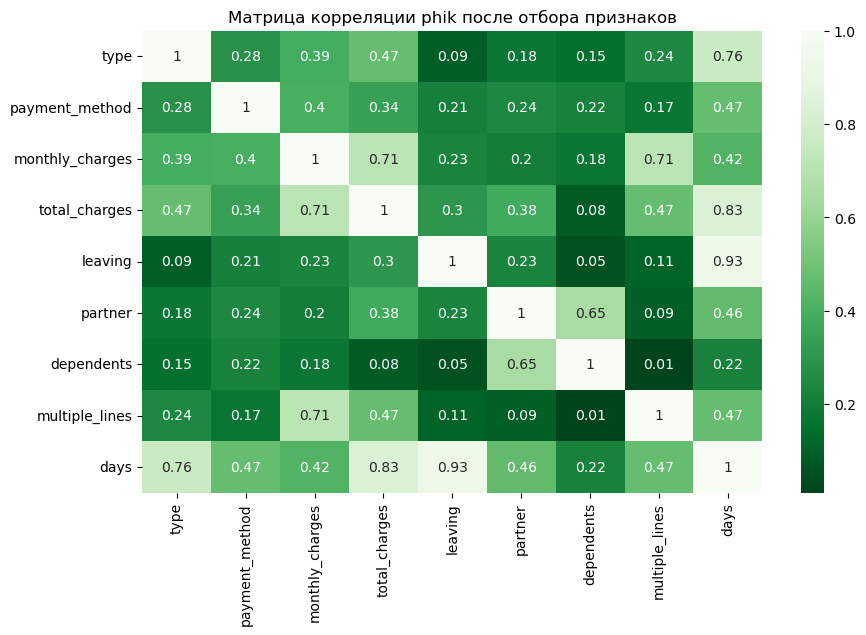

In [73]:
matrix = (final_data
          .phik_matrix(interval_cols=['monthly_charges', 'total_charges']).round(2))
plt.figure(figsize=(10,6))
sns.heatmap(data=matrix, annot=True, cmap='Greens_r')
plt.title('Матрица корреляции phik после отбора признаков')
plt.show()

### Выводы по обучению моделей МО
#### Лучшая модель
- Лучшая модель - CatBoostClassifier с шагом обучения 0.03, 4500 итераций, коэффициентом L2-регуляризации 0.1, автоматическими весами классов, максимальной глубной дерева 4. Ее метрика на тестовой выборке после отбора признаков 0.92, Accuracy (точность) 0.9.
#### Важность признаков
- Сильно на отвал влияет длительность договора: высокие и средние значения говорят о перевесе в сторону лояльности и не намекают на разрыв договора, в то время как более низкие значения сводят к тому, что клиент имеет риск отвалиться;
- Сильно влияет Тип оплаты: к отвалу значительно менее склонны оплачивающие помесячно и более склонны остальные, очень сильно склонны оплачивающие раз в 2 года;
- Клиенты с очень низкой или очень высокая сумма общих расходов менее склонны к отвалу (то есть новые клиенты и "звезды" по общей выручке), средние значения говорят о большей склонности к отвалу;
- Клиенты с низкими и средними месячными расходами менее склонны к отвалу, чем клиенты с высокими;
- Не женатые менее склонны к отвалу, чем женатые;
- Не пользующиеся сервисом с параллельными линиями менее склонные к отвалу;
- Клиенты, получающие счет на почту, менее всех склонны к отвалу;
- Клиенты с детьми менее склонны к отвалу.
- Признаки пенсионер по возрасту и получение не бумажного чека удалены из-за недостаточной важности, метрика ROC-AUC улучшилась.

## Отчет по задаче (итоговый вывод)

### Предобработка данных
- Данные проверены на наличие явных дубликатов, они отсутствуют;
- Данные проверены на явные и неявные пропуски, они устранены;
- Обработаны типы данных, названия столбцов.

### EDA
#### Анализ данных
- Целевой признак "отвал": Присутствует классовый дисбаланс: на каждого отвалившегося клиента есть почти 6 действующих: Из 7 клиентов отваливается только 1.
- Расходы в месяц: Распределения по форме примерно похожи среди всех трех обозреваемых групп, не имеют форму нормального. Наибольшее количество клиентов (около 15%) за месяц тратят 18.25 рублей, предполагаем, что это минимальный месячный тариф у заказчика. Остальные данные распределены мультимодально (50, 70, 80, 90) отдаленно напоминающе сильно сжатое нормальное распределение со средним около 70.
Обратили внимание, что медианный и средний чек месячных расходов у ушедших клиентов чуть выше, чем у действующих (среднее 75 против 62, медиана 84 против 70), а также у отвалившихся клиентов месячные расходы выше чем у действующих на всех уровнях (относительная частота корзин с бóльшими расходами у отвалившихся выше, чем у действующих). Гипотеза подтверждена статистически.
- Общие расходы: Распределение общих расходов не имеет форму нормального: чем меньше сумма, тем больше частота. Присутствует значительный пик в около 19 на графиках среди всех и действующих клиентов. Гипотеза подтверждена статистически.
Обратим внимание, что среди отвалившихся клиентов нет тех, чьи общие расходы меньше 77. Помимо этого, среднее (на 10%) и медиана (почти вдвое) среди отвалившихся больше, стандартное отклонение меньше почти на 25%, это говорит о большей однородности данных.
- Проведен анализ распределений категориальных признаков, выявлены предположения, что использование сервисов может влиять на вероятность того, что клиент может отвалиться. Эти предположения будут проверены после построения моделей МО и анализа важности признаков.

#### Создание признаков
- Создан новый признак - длительность договора (дней). Распределение среди действующих не нормальное. Присутствует пик около 200 и 2200: это новые клиенты и большое количество "постоянников". Среди "отвалов" распределение похоже на нормальное со средним 924.

#### Корреляционный анализ
- Мультиколлинеарность: Тип интернет-кабеля в сильной зависимости с месячными расходами; дата окончания договора - с целевой переменной (и это объясняется тем, что целевой признак мы выделяли из даты окончания); использование интернет-сервисов сильно коррелирует друг с другом (каждый с каждым);
- Сильнее всего с целевым признаком коррелирует дата начала договора и длительность договора.

#### Итоговая матрица корреляции признаков, которые были использованы для обучения лучшей модели
Целевой признак - leaving

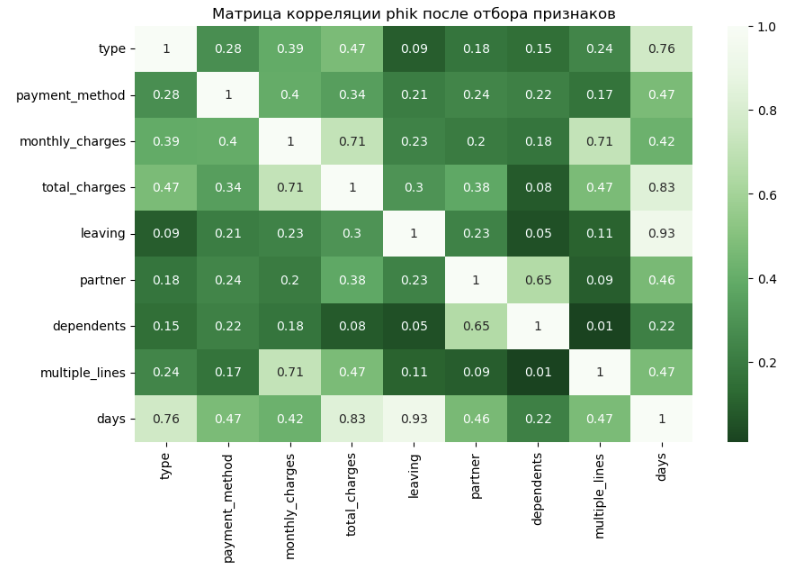

### Обучение моделей МО
#### Лучшая модель
- Лучшая модель - final_model: CatBoostClassifier с шагом обучения 0.03, 4500 итераций, коэффициентом L2-регуляризации 0.1, автоматическими весами классов, максимальной глубной дерева 4 (CatBoostClassifier(learning_rate=0.03, leaf_reg=0.1, verbose=False, auto_class_weights='Balanced', max_depth=4, iterations=4500, random_state=240225)). Ее ROC-AUC на тестовой выборке после отбора признаков 0.92, Accuracy (точность) 0.9.
- Матрица ошибок

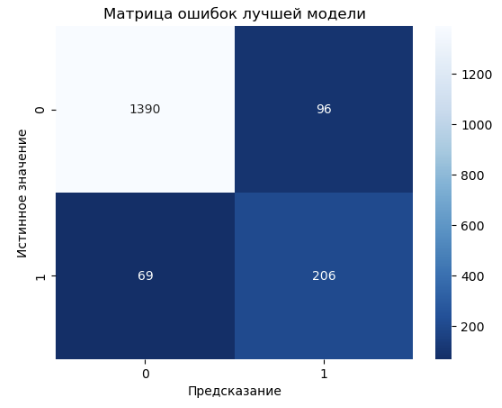


- Кривая ROC:

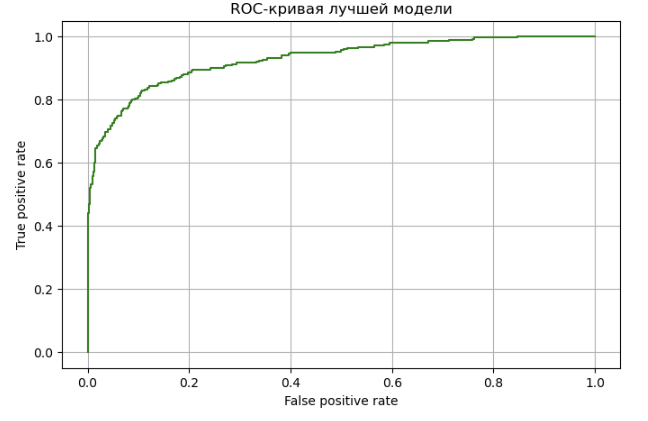


#### Важность признаков
- Сильно на отвал влияет длительность договора: высокие и средние значения говорят о перевесе в сторону лояльности и не намекают на разрыв договора, в то время как более низкие значения сводят к тому, что клиент имеет риск отвалиться;
- Сильно влияет Тип оплаты: к отвалу значительно менее склонны оплачивающие помесячно и более склонны остальные, очень сильно склонны оплачивающие раз в 2 года;
- Клиенты с очень низкой или очень высокая сумма общих расходов менее склонны к отвалу (то есть новые клиенты и "звезды" по общей выручке), средние значения говорят о большей склонности к отвалу;
- Клиенты с низкими и средними месячными расходами менее склонны к отвалу, чем клиенты с высокими;
- Не женатые менее склонны к отвалу, чем женатые;
- Не пользующиеся сервисом с параллельными линиями менее склонные к отвалу;
- Клиенты, получающие счет на почту, менее всех склонны к отвалу;
- Клиенты с детьми менее склонны к отвалу.
- Признаки пенсионер по возрасту и получение не бумажного чека удалены из-за недостаточной важности, метрика ROC-AUC улучшилась.

### Рекомендации для заказчика
1. Рекомендуем к использованию модель final_model в исходном виде для прогнозирования оттока клиентов (ее точность 0.9);
2. Рекомендуем переводить действующих клиентов на помесячную оплату с получением счета на почту, это позволит снизить риски отвала, основываясь на анализе важности признаков лучшей модели. Чтобы клиенты более охотно переходили на такой формат оплаты, рекомендуем разослать всем клиентам, которые оплачивают ежегодно или раз в 2 года письмо и уведомление о том, что в рамках новой акции можно будет получить скидку на обслуживание, если получать счет на почту и перевести оплату на помесячную.
3. Так как клиенты с большей длительностью договора и меньшей суммой расходов (всего и месячных) менее склонны к отвалу, рекомендуем всем действующим клиентам со склонностью к отвалу на основании предсказаний модели отправить промокод на скидку, чтобы снизить сумму их расходов и/или подарить месяц бесплатного обслуживания для тех же целей.
4. Так как использующие сервис с параллельными линиями более склонны к отвалу, рекомендуем проверить, довольны ли эти клиенты качеством услуг, предоставляемых в рамках этого сервиса, так как это может быть причиной повышенной склонности к отвалу. Если гипотеза подтвердится, то рекомендуем пересмотреть подходы и повысить качество услуг, чтобы этот признак не оказывал дополнительного отрицательного влияния на отвал.